In [ ]:
# Unmount if it was previously mounted
!fusermount -u /content/drive

# Remove any leftover files/folders
!rm -rf /content/drive

# Now try mounting again
from google.colab import drive
drive.mount('/content/drive')

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


# **Mục 0 — Thiết lập cấu hình thí nghiệm (Experiment Configuration)**

In [ ]:
# =========================
# 0.0 EXPERIMENT CONFIG (CLEAN)
# =========================
EXP_NAME = "LiTS2D_UNet_vs_UNetTx_CE_Dice"
SEED = 42

# ---------- PROJECT ROOT (notebook folder) ----------
PROJECT_ROOT = "/content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8"

# ---------- OUTPUT ROOT (experiments_lits) ----------
OUT_ROOT = os.path.join(PROJECT_ROOT, "experiments_lits")   # <- điểm neo rõ ràng

# ---------- DATA ROOTS ----------
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/dataset"
SEG_DIR   = os.path.join(DATA_ROOT, "segmentations")
VOL_DIR   = os.path.join(DATA_ROOT, "volumes")

# ---------- INPUT / PREPROCESS ----------
IMG_SIZE = 256
NUM_CLASSES = 3
HU_MIN, HU_MAX = -100, 400
AXIS_SLICE = 2

# ---------- SPLIT (patient-level) ----------
SPLIT = dict(train=0.70, val=0.15, test=0.15)

# ---------- TRAINING ----------
BATCH_SIZE = 8
LR = 1e-4
EPOCHS_BASELINE = 30
EPOCHS_TX = 30
BASE_FILTERS = 32

USE_AUG = True
USE_CACHE = True
USE_TENSORBOARD = True

# ---------- SAMPLING / FILTER ----------
KEEP_ONLY_LIVER = True
TUMOR_TARGET_RATIO = 0.30
MAX_DUP = 10

# ---------- LOSS ----------
ALPHA_DICE = 0.5

# ---------- MODELS ----------
RUN_MODELS = ["UNet_Baseline", "UNet_TxBottleneck"]

print("EXP_NAME:", EXP_NAME)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("OUT_ROOT:", OUT_ROOT)
print("DATA_ROOT:", DATA_ROOT)
print("SEG_DIR:", SEG_DIR)
print("VOL_DIR:", VOL_DIR)
print("IMG_SIZE:", IMG_SIZE, "| NUM_CLASSES:", NUM_CLASSES, "| HU:", (HU_MIN, HU_MAX), "| AXIS:", AXIS_SLICE)
print("SPLIT:", SPLIT, "| SEED:", SEED)
print("BATCH_SIZE:", BATCH_SIZE, "| LR:", LR, "| EPOCHS:", (EPOCHS_BASELINE, EPOCHS_TX))
print("RUN_MODELS:", RUN_MODELS)

EXP_NAME: LiTS2D_UNet_vs_UNetTx_CE_Dice
PROJECT_ROOT: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8
OUT_ROOT: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits
DATA_ROOT: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/dataset
SEG_DIR: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/dataset/segmentations
VOL_DIR: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/dataset/volumes
IMG_SIZE: 256 | NUM_CLASSES: 3 | HU: (-100, 400) | AXIS: 2
SPLIT: {'train': 0.7, 'val': 0.15, 'test': 0.15} | SEED: 42
BATCH_SIZE: 8 | LR: 0.0001 | EPOCHS: (30, 30)
RUN_MODELS: ['UNet_Baseline', 'UNet_TxBottleneck']


In [ ]:
# =========================
# 0.1 SET SEED + DETERMINISM (BEST EFFORT)
# =========================
import os, random, numpy as np
import tensorflow as tf

def set_seed(seed=42, deterministic=False):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # best-effort deterministic
    if deterministic:
        os.environ["TF_DETERMINISTIC_OPS"] = "1"
        try:
            tf.config.experimental.enable_op_determinism(True)
        except Exception:
            pass

set_seed(SEED, deterministic=True)
print("✅ Seed set:", SEED, "| deterministic(best-effort)=True")

✅ Seed set: 42 | deterministic(best-effort)=True


In [ ]:
# =========================
# 0.2 OUTPUT FOLDERS (ONE RUN)
# =========================
import os
from datetime import datetime

os.makedirs(OUT_ROOT, exist_ok=True)

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_ROOT = os.path.join(OUT_ROOT, EXP_NAME, RUN_ID)

DIRS = {
    "run_root":  RUN_ROOT,
    "models":    os.path.join(RUN_ROOT, "models"),
    "logs":      os.path.join(RUN_ROOT, "logs"),
    "figures":   os.path.join(RUN_ROOT, "figures"),
    "csv":       os.path.join(RUN_ROOT, "csv"),
    "artifacts": os.path.join(RUN_ROOT, "artifacts"),
    # nơi lưu npy chuẩn hoá
    "npy_root":  os.path.join(RUN_ROOT, "artifacts", "npy_2d"),
}

for p in DIRS.values():
    os.makedirs(p, exist_ok=True)

print("✅ RUN_ROOT:", RUN_ROOT)
for k,v in DIRS.items():
    print(f" - {k}: {v}")

✅ RUN_ROOT: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633
 - run_root: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633
 - models: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/models
 - logs: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/logs
 - figures: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_

In [ ]:
# =========================
# 0.3 CHECK PATHS (FAIL FAST)
# =========================
import os

for p, name in [
    (PROJECT_ROOT, "PROJECT_ROOT"),
    (OUT_ROOT, "OUT_ROOT"),
    (DATA_ROOT, "DATA_ROOT"),
    (SEG_DIR, "SEG_DIR"),
    (VOL_DIR, "VOL_DIR"),
]:
    assert os.path.isdir(p), f"❌ {name} not found: {p}"

print("✅ All key paths exist.")

✅ All key paths exist.


In [ ]:
# =========================
# 0.4 SAVE CONFIG + MANIFEST
# =========================
import json, platform, sys, subprocess
import tensorflow as tf

def get_gpu_info():
    info = {"tf_gpus": [str(g) for g in tf.config.list_physical_devices("GPU")]}
    try:
        out = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=name,memory.total,driver_version", "--format=csv,noheader"]
        ).decode().strip()
        info["nvidia_smi"] = out
    except Exception as e:
        info["nvidia_smi"] = f"n/a ({e})"
    return info

CONFIG = {
    "exp_name": EXP_NAME,
    "run_id": RUN_ID,
    "seed": SEED,
    "paths": {
        "project_root": PROJECT_ROOT,
        "out_root": OUT_ROOT,
        "data_root": DATA_ROOT,
        "seg_dir": SEG_DIR,
        "vol_dir": VOL_DIR,
        "run_root": RUN_ROOT,
    },
    "dirs": DIRS,
    "input": {"img_size": IMG_SIZE, "num_classes": NUM_CLASSES, "hu_window": [HU_MIN, HU_MAX], "axis_slice": AXIS_SLICE},
    "split": SPLIT,
    "training": {
        "batch_size": BATCH_SIZE, "lr": float(LR),
        "epochs_baseline": EPOCHS_BASELINE, "epochs_tx": EPOCHS_TX,
        "base_filters": BASE_FILTERS,
        "use_aug": USE_AUG, "use_cache": USE_CACHE, "use_tensorboard": USE_TENSORBOARD,
    },
    "sampling": {"keep_only_liver": KEEP_ONLY_LIVER, "tumor_target_ratio": TUMOR_TARGET_RATIO, "max_dup": MAX_DUP},
    "loss": {"type": "CE + Dice (no background)", "alpha_dice": ALPHA_DICE},
    "models": RUN_MODELS,
    "environment": {
        "python": sys.version,
        "platform": platform.platform(),
        "tensorflow": tf.__version__,
        "gpu": get_gpu_info(),
    },
}

cfg_path = os.path.join(DIRS["artifacts"], "config.json")
with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump(CONFIG, f, ensure_ascii=False, indent=2)

# Manifest: các file “dự kiến” sẽ có sau pipeline
MANIFEST = {
    "expected": {
        "npy": {
            "train_x": os.path.join(DIRS["npy_root"], "images", "train.npy"),
            "train_y": os.path.join(DIRS["npy_root"], "masks",  "train.npy"),
            "val_x":   os.path.join(DIRS["npy_root"], "images", "val.npy"),
            "val_y":   os.path.join(DIRS["npy_root"], "masks",  "val.npy"),
            "test_x":  os.path.join(DIRS["npy_root"], "images", "test.npy"),
            "test_y":  os.path.join(DIRS["npy_root"], "masks",  "test.npy"),
        },
        "csv": {
            "baseline_history": os.path.join(DIRS["csv"], "history_UNet_Baseline.csv"),
            "tx_history":       os.path.join(DIRS["csv"], "history_UNet_TxBottleneck.csv"),
            "compare_models":   os.path.join(DIRS["csv"], "compare_models.csv"),
        },
        "models": {
            "baseline_best": os.path.join(DIRS["models"], "UNet_Baseline_best.keras"),
            "tx_best":       os.path.join(DIRS["models"], "UNet_TxBottleneck_best.keras"),
        }
    }
}

manifest_path = os.path.join(DIRS["artifacts"], "run_manifest.json")
with open(manifest_path, "w", encoding="utf-8") as f:
    json.dump(MANIFEST, f, ensure_ascii=False, indent=2)

print("✅ Saved:", cfg_path)
print("✅ Saved:", manifest_path)
print("GPU info:", CONFIG["environment"]["gpu"])

✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/artifacts/config.json
✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/artifacts/run_manifest.json
GPU info: {'tf_gpus': ["PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')"], 'nvidia_smi': 'NVIDIA L4, 23034 MiB, 550.54.15'}


In [ ]:
# =========================
# 0.5 RESOURCE LOGGER (OPTIONAL)
# =========================
import time
import tensorflow as tf

try:
    import psutil
    _HAS_PSUTIL = True
except:
    _HAS_PSUTIL = False

class ResourceLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times, self.ram_mb, self.vram_mb = [], [], []

    def _get_vram_mb(self):
        try:
            import subprocess
            out = subprocess.check_output(
                ["nvidia-smi", "--query-gpu=memory.used", "--format=csv,noheader,nounits"]
            ).decode().strip().split("\n")[0]
            return float(out)
        except:
            return None

    def on_epoch_begin(self, epoch, logs=None):
        self._t0 = time.time()

    def on_epoch_end(self, epoch, logs=None):
        dt = time.time() - self._t0
        ram = None
        if _HAS_PSUTIL:
            ram = psutil.virtual_memory().used / (1024**2)

        vram = self._get_vram_mb()
        self.epoch_times.append(dt)
        self.ram_mb.append(ram if ram is not None else -1)
        self.vram_mb.append(vram if vram is not None else -1)

        print(f"[Resource] epoch={epoch+1} time={dt:.1f}s | RAM={ram if ram is not None else 'n/a'}MB | VRAM={vram if vram is not None else 'n/a'}MB")

resource_cb = ResourceLogger()
print("✅ ResourceLogger ready.")

✅ ResourceLogger ready.


# **Mục 1 – Chuẩn bị môi trường Colab**

In [ ]:
# =========================
# 1.1 MOUNT GOOGLE DRIVE
# =========================
from google.colab import drive
import os, subprocess

MOUNT_POINT = "/content/drive"

def safe_mount_drive(mount_point="/content/drive"):
    # nếu đã mount và có dữ liệu -> dùng luôn
    if os.path.ismount(mount_point):
        print("ℹ️ Drive already mounted at", mount_point)
        return

    # nếu thư mục tồn tại nhưng lỗi trạng thái -> dọn sạch
    if os.path.exists(mount_point):
        try:
            subprocess.run(["fusermount", "-u", mount_point], check=False)
        except:
            pass
        try:
            subprocess.run(["umount", mount_point], check=False)
        except:
            pass
        try:
            subprocess.run(["rm", "-rf", mount_point], check=False)
        except:
            pass

    os.makedirs(mount_point, exist_ok=True)
    drive.mount(mount_point)

safe_mount_drive(MOUNT_POINT)
print("✅ Google Drive mounted at:", MOUNT_POINT)

ℹ️ Drive already mounted at /content/drive
✅ Google Drive mounted at: /content/drive


In [ ]:
# =========================
# 1.2 CONFIGURE GPU (TF) + OPTIONAL MIXED PRECISION
# =========================
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
print("TF version:", tf.__version__)
print("GPUs:", gpus)

if gpus:
    # IMPORTANT: allow growth to reduce OOM risk
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Enabled memory growth for GPUs.")
    except Exception as e:
        print("⚠️ Could not set memory growth:", e)

    # OPTIONAL: Mixed precision (reduce VRAM)
    USE_MIXED_PRECISION = True   # đổi False nếu bạn muốn fp32
    if USE_MIXED_PRECISION:
        try:
            from tensorflow.keras import mixed_precision
            mixed_precision.set_global_policy("mixed_float16")
            print("✅ Mixed precision enabled: mixed_float16")
        except Exception as e:
            print("⚠️ Mixed precision not enabled:", e)
else:
    print("❌ GPU NOT FOUND. Runtime → Change runtime type → GPU")

TF version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Enabled memory growth for GPUs.
✅ Mixed precision enabled: mixed_float16


In [ ]:
# =========================
# 1.3 CHECK NVIDIA-SMI
# =========================
import subprocess

try:
    smi = subprocess.check_output(
        ["nvidia-smi", "--query-gpu=name,memory.total,memory.used,driver_version", "--format=csv"]
    ).decode()
    print(smi)
except Exception as e:
    print("⚠️ nvidia-smi not available:", e)

name, memory.total [MiB], memory.used [MiB], driver_version
NVIDIA L4, 23034 MiB, 3 MiB, 550.54.15



In [ ]:
# =========================
# 1.4 CHECK SYSTEM RAM
# =========================
try:
    import psutil
    mem = psutil.virtual_memory()
    print(f"Total RAM : {mem.total / (1024**3):.2f} GB")
    print(f"Used  RAM : {mem.used  / (1024**3):.2f} GB")
    print(f"Free  RAM : {mem.available / (1024**3):.2f} GB")
except Exception as e:
    print("⚠️ psutil not available:", e)

Total RAM : 52.96 GB
Used  RAM : 1.89 GB
Free  RAM : 50.45 GB


In [ ]:
# =========================
# 1.5 VERIFY RUN + LOG ENV (to artifacts)
# =========================
import os, sys, json, platform, subprocess
import tensorflow as tf

assert "DIRS" in globals() and isinstance(DIRS, dict), "DIRS must be a dict (run folders)."
assert os.path.isdir(DIRS["run_root"]), f"RUN_ROOT missing: {DIRS['run_root']}"
assert os.path.isdir(DIRS["artifacts"]), f"artifacts missing: {DIRS['artifacts']}"

print("✅ RUN_ROOT:", DIRS["run_root"])
print("✅ Artifacts:", DIRS["artifacts"])

# quick check config.json exists
cfg_path = os.path.join(DIRS["artifacts"], "config.json")
print("config.json:", "FOUND" if os.path.exists(cfg_path) else "MISSING", "|", cfg_path)

def try_cmd(cmd):
    try:
        return subprocess.check_output(cmd).decode().strip()
    except Exception as e:
        return f"n/a ({e})"

env_report = {
    "python": sys.version,
    "platform": platform.platform(),
    "tensorflow": tf.__version__,
    "tf_gpus": [str(g) for g in tf.config.list_physical_devices("GPU")],
    "nvidia_smi": try_cmd(["nvidia-smi"]),
    "pip_freeze_head": "\n".join(try_cmd(["pip", "freeze"]).splitlines()[:80]),
}

env_path = os.path.join(DIRS["artifacts"], "env_report.json")
with open(env_path, "w", encoding="utf-8") as f:
    json.dump(env_report, f, ensure_ascii=False, indent=2)

print("✅ Saved env report:", env_path)

✅ RUN_ROOT: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633
✅ Artifacts: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/artifacts
config.json: FOUND | /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/artifacts/config.json
✅ Saved env report: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/artifacts/env_report.json


# **Mục 2 – Cài đặt & import thư viện**

In [ ]:
# =========================
# 2.0 CHECK DRIVE + RUN FOLDERS (FAIL FAST)
# =========================
import os

assert os.path.ismount("/content/drive"), "Drive chưa mount. Hãy chạy Mục 1.1 trước."
print("✅ Drive OK:", "/content/drive")

assert "DIRS" in globals() and isinstance(DIRS, dict), "DIRS must be defined in Mục 0.2"
for k in ["run_root", "models", "csv", "figures", "artifacts"]:
    assert os.path.isdir(DIRS[k]), f"Missing DIRS['{k}']: {DIRS[k]}"
print("✅ DIRS OK:", DIRS["run_root"])

✅ Drive OK: /content/drive
✅ DIRS OK: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633


In [ ]:
# =========================
# 2.1 INSTALL REQUIRED LIBS (INSTALL-IF-MISSING, ROBUST)
# =========================
import importlib, subprocess, sys

def ensure_import(import_name: str, pip_name: str = None):
    """
    import_name: tên module để import (vd: 'nibabel', 'skimage', 'tqdm', 'psutil')
    pip_name: tên gói pip (vd: 'scikit-image', 'opencv-python-headless')
    """
    pip_name = pip_name or import_name
    try:
        importlib.import_module(import_name)
        print(f"✅ {pip_name} already installed")
        return True
    except Exception:
        print(f"⬇️ Installing: {pip_name}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])
        return False

# Medical IO / processing
ensure_import("nibabel", "nibabel")
ensure_import("skimage", "scikit-image")
ensure_import("scipy", "scipy")

# OpenCV (headless for Colab)
ensure_import("cv2", "opencv-python-headless")

# Utilities
ensure_import("tqdm", "tqdm")
ensure_import("psutil", "psutil")
ensure_import("pandas", "pandas")
ensure_import("matplotlib", "matplotlib")

print("✅ Done installing (if needed).")

✅ nibabel already installed
✅ scikit-image already installed
✅ scipy already installed
✅ opencv-python-headless already installed
✅ tqdm already installed
✅ psutil already installed
✅ pandas already installed
✅ matplotlib already installed
✅ Done installing (if needed).


In [ ]:
# =========================
# 2.2 SYSTEM IMPORTS + HELPERS
# =========================
import os, json, time, math, random
import numpy as np

def save_json(obj, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

class Timer:
    def __init__(self, name="timer"):
        self.name = name
    def __enter__(self):
        self.t0 = time.time()
        return self
    def __exit__(self, exc_type, exc, tb):
        dt = time.time() - self.t0
        print(f"[{self.name}] {dt:.2f}s")

np.set_printoptions(precision=4, suppress=True)
print("✅ System helpers ready")

✅ System helpers ready


In [ ]:
# =========================
# 2.3 MEDICAL IMAGE + PROCESSING IMPORTS
# =========================
import nibabel as nib
import cv2
import scipy.ndimage as ndi

from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, remove_small_holes

print("✅ Medical imaging libs imported")
print("NumPy   :", np.__version__)
print("Nibabel :", nib.__version__)
print("OpenCV  :", cv2.__version__)

✅ Medical imaging libs imported
NumPy   : 2.0.2
Nibabel : 5.3.3
OpenCV  : 4.12.0


In [ ]:
# =========================
# 2.4 DEEP LEARNING IMPORTS (TF/KERAS)
# =========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

print("✅ TensorFlow:", tf.__version__)
print("✅ Keras backend:", keras.backend.backend())
print("TF GPUs:", tf.config.list_physical_devices("GPU"))

# NOTE: memory growth nên set ở Mục 1.2; ở đây chỉ nhắc nếu chưa bật

✅ TensorFlow: 2.19.0
✅ Keras backend: tensorflow
TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# =========================
# 2.5 VISUALIZATION IMPORTS
# =========================
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["image.cmap"] = "gray"

print("✅ Matplotlib ready")

✅ Matplotlib ready


In [ ]:
# =========================
# 2.6 LOG LIB VERSIONS to artifacts
# =========================
import pandas as pd

versions = {
    "numpy": np.__version__,
    "nibabel": nib.__version__,
    "opencv": cv2.__version__,
    "tensorflow": tf.__version__,
    "keras_backend": keras.backend.backend(),
    "pandas": pd.__version__,
}

ver_path = os.path.join(DIRS["artifacts"], "versions.json")
save_json(versions, ver_path)
print("✅ Saved versions:", ver_path)
print(versions)

✅ Saved versions: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/artifacts/versions.json
{'numpy': '2.0.2', 'nibabel': '5.3.3', 'opencv': '4.12.0', 'tensorflow': '2.19.0', 'keras_backend': 'tensorflow', 'pandas': '2.2.2'}


# **Mục 3 – Tổ chức & kiểm tra dữ liệu**

In [ ]:
# =========================
# 3.0 DATA PATHS (UPDATED)
# =========================
import os

DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/dataset"
SEG_DIR   = "/content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/dataset/segmentations"
VOL_DIR   = "/content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/dataset/volumes"

print("DATA_ROOT:", DATA_ROOT)
print("SEG_DIR  :", SEG_DIR)
print("VOL_DIR  :", VOL_DIR)

DATA_ROOT: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/dataset
SEG_DIR  : /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/dataset/segmentations
VOL_DIR  : /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/dataset/volumes


In [ ]:
# =========================
# 3.1 CHECK FOLDER STRUCTURE
# =========================
import os

assert os.path.isdir(DATA_ROOT), f"❌ DATA_ROOT not found: {DATA_ROOT}"
assert os.path.isdir(SEG_DIR),   f"❌ SEG_DIR not found: {SEG_DIR}"
assert os.path.isdir(VOL_DIR),   f"❌ VOL_DIR not found: {VOL_DIR}"

seg_files = sorted([f for f in os.listdir(SEG_DIR) if f.endswith(".nii") or f.endswith(".nii.gz")])
vol_folders = sorted([d for d in os.listdir(VOL_DIR) if os.path.isdir(os.path.join(VOL_DIR, d))])

print("✅ SEG files:", len(seg_files), "| sample:", seg_files[:5])
print("✅ VOL folders:", len(vol_folders), "| sample:", vol_folders[:5])

pt_folders = sorted([d for d in vol_folders if d.startswith("volume_pt")])
print("✅ volume_pt* folders:", len(pt_folders), "| sample:", pt_folders[:5])

✅ SEG files: 131 | sample: ['segmentation-0.nii', 'segmentation-1.nii', 'segmentation-10.nii', 'segmentation-100.nii', 'segmentation-101.nii']
✅ VOL folders: 13 | sample: ['volume_pt1', 'volume_pt10', 'volume_pt11', 'volume_pt12', 'volume_pt13']
✅ volume_pt* folders: 13 | sample: ['volume_pt1', 'volume_pt10', 'volume_pt11', 'volume_pt12', 'volume_pt13']


In [ ]:
# =========================
# 3.2 BUILD INDEX MAPS (id -> file path)
# =========================
import os, re, glob

def _extract_id(filename, prefix):
    # prefix: "volume-" or "segmentation-"
    # supports .nii or .nii.gz
    m = re.match(rf"{re.escape(prefix)}(\d+)\.nii(\.gz)?$", filename)
    return int(m.group(1)) if m else None

def build_seg_index(seg_dir):
    files = glob.glob(os.path.join(seg_dir, "segmentation-*.nii*"))
    idx_to_path = {}
    for fp in files:
        pid = _extract_id(os.path.basename(fp), "segmentation-")
        if pid is not None:
            idx_to_path[pid] = fp
    return dict(sorted(idx_to_path.items()))

def build_volume_index(vol_root):
    # dataset/volumes/volume_pt*/volume-*.nii(.gz)
    files = glob.glob(os.path.join(vol_root, "volume_pt*", "volume-*.nii*"))
    idx_to_path = {}
    for fp in files:
        pid = _extract_id(os.path.basename(fp), "volume-")
        if pid is not None:
            idx_to_path[pid] = fp
    return dict(sorted(idx_to_path.items()))

seg_map = build_seg_index(SEG_DIR)
vol_map = build_volume_index(VOL_DIR)

print("Found segmentations:", len(seg_map))
print("Found volumes      :", len(vol_map))

if seg_map:
    print("Seg id range:", min(seg_map), "->", max(seg_map))
if vol_map:
    print("Vol id range:", min(vol_map), "->", max(vol_map))

Found segmentations: 131
Found volumes      : 131
Seg id range: 0 -> 130
Vol id range: 0 -> 130


In [ ]:
# =========================
# 3.3 MATCH CHECK (volume <-> segmentation)
# =========================
vol_ids = set(vol_map.keys())
seg_ids = set(seg_map.keys())

matched = sorted(list(vol_ids & seg_ids))
vol_only = sorted(list(vol_ids - seg_ids))
seg_only = sorted(list(seg_ids - vol_ids))

print("✅ Matched pairs:", len(matched))
print("⚠️ Volume-only  :", len(vol_only))
print("⚠️ Seg-only     :", len(seg_only))

if vol_only:
    print("Example vol_only:", vol_only[:10])
if seg_only:
    print("Example seg_only:", seg_only[:10])

assert len(matched) > 0, "❌ No matched (volume, segmentation) pairs found!"

✅ Matched pairs: 131
⚠️ Volume-only  : 0
⚠️ Seg-only     : 0


In [ ]:
# =========================
# 3.4 SHAPE + LABEL SANITY CHECK (few patients)
# =========================
import numpy as np
import nibabel as nib

def load_shape_dtype(path):
    img = nib.load(path)
    arr = img.get_fdata()
    return arr.shape, arr.dtype

def sample_patient_ids(matched_ids, n=3):
    if len(matched_ids) <= n:
        return matched_ids
    # lấy 3 điểm rải đều
    return [matched_ids[0], matched_ids[len(matched_ids)//2], matched_ids[-1]]

sample_ids = sample_patient_ids(matched, n=3)
print("Sample ids:", sample_ids)

for pid in sample_ids:
    v_path = vol_map[pid]
    s_path = seg_map[pid]

    v_shape, v_dtype = load_shape_dtype(v_path)
    s_shape, s_dtype = load_shape_dtype(s_path)

    # mask unique (đọc nhanh -> uint8)
    s_arr = nib.load(s_path).get_fdata().astype(np.uint8)
    uniq = np.unique(s_arr)

    print(f"\nPatient {pid}")
    print(" Volume:", v_shape, v_dtype, "|", os.path.basename(v_path))
    print(" Seg   :", s_shape, s_dtype, "| unique:", uniq, "|", os.path.basename(s_path))

    assert v_shape == s_shape, f"❌ Shape mismatch at patient {pid}: {v_shape} vs {s_shape}"
    assert set(uniq).issubset({0,1,2}), f"❌ Unexpected labels at patient {pid}: {uniq}"

Sample ids: [0, 65, 130]

Patient 0
 Volume: (512, 512, 75) float64 | volume-0.nii
 Seg   : (512, 512, 75) float64 | unique: [0 1 2] | segmentation-0.nii

Patient 65
 Volume: (512, 512, 513) float64 | volume-65.nii
 Seg   : (512, 512, 513) float64 | unique: [0 1 2] | segmentation-65.nii

Patient 130
 Volume: (512, 512, 624) float64 | volume-130.nii
 Seg   : (512, 512, 624) float64 | unique: [0 1 2] | segmentation-130.nii


In [ ]:
# =========================
# 3.5 QUICK DATASET STATS (slice-level)
# =========================
import numpy as np
import nibabel as nib

FULL_SCAN = True   # True nếu bạn muốn quét toàn bộ dataset

def slice_presence_stats(seg_path):
    seg = nib.load(seg_path).get_fdata().astype(np.uint8)
    D = seg.shape[2]
    has_liver = 0
    has_tumor = 0
    for z in range(D):
        m = seg[:, :, z]
        if np.any((m == 1) | (m == 2)):
            has_liver += 1
        if np.any(m == 2):
            has_tumor += 1
    return D, has_liver, has_tumor

ids_to_scan = matched if FULL_SCAN else sample_patient_ids(matched, n=5)
print("Scanning patients:", ids_to_scan)

rows = []
for pid in ids_to_scan:
    D, L, T = slice_presence_stats(seg_map[pid])
    rows.append({"patient_id": pid, "total_slices": D, "liver_slices": L, "tumor_slices": T})

import pandas as pd
df_stats = pd.DataFrame(rows)
display(df_stats)

print("\nSummary:")
print(df_stats[["total_slices","liver_slices","tumor_slices"]].describe())

Scanning patients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]


patient_id  total_slices  liver_slices  tumor_slices
0             0            75            29            16
1             1           123            29            18
2             2           517           139            29
3             3           534           169            15
4             4           841           250           244
..          ...           ...           ...           ...
126         126           401           113            15
127         127           987           227             3
128         128           654           292           144
129         129           338           277           226
130         130           624           241           199

[131 rows x 4 columns]


Summary:
       total_slices  liver_slices  tumor_slices
count    131.000000    131.000000    131.000000
mean     447.618321    146.282443     54.885496
std      275.250025     73.004771     62.453385
min       74.000000     29.000000      0.000000
25%      190.000000     89.000000     10.500000
50%      432.000000    133.000000     30.000000
75%      684.000000    196.000000     79.000000
max      987.000000    299.000000    245.000000


In [ ]:
# =========================
# 3.6 SAVE INDEX MAPS + MATCHED IDS
# =========================
import json

index_info = {
    "num_volumes": len(vol_map),
    "num_segmentations": len(seg_map),
    "num_matched": len(matched),
    "matched_ids": matched,
}

index_path = os.path.join(DIRS["artifacts"], "index_maps.json")
with open(index_path, "w", encoding="utf-8") as f:
    json.dump(index_info, f, indent=2)

print("✅ Saved index map info:", index_path)

✅ Saved index map info: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/artifacts/index_maps.json


In [ ]:
# =========================
# 3.7 FULL DATASET SLICE STATS (RUN ONCE)
# =========================
import pandas as pd

rows = []
for pid in matched:
    D, L, T = slice_presence_stats(seg_map[pid])
    rows.append({
        "patient_id": pid,
        "total_slices": D,
        "liver_slices": L,
        "tumor_slices": T,
        "tumor_ratio": T / max(L, 1),
    })

df_all_stats = pd.DataFrame(rows)

stats_csv = os.path.join(DIRS["artifacts"], "slice_stats_all_patients.csv")
df_all_stats.to_csv(stats_csv, index=False)

print("✅ Saved full slice stats:", stats_csv)
df_all_stats.describe()

✅ Saved full slice stats: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/artifacts/slice_stats_all_patients.csv


patient_id  total_slices  liver_slices  tumor_slices  tumor_ratio
count  131.000000    131.000000    131.000000    131.000000   131.000000
mean    65.000000    447.618321    146.282443     54.885496     0.348835
std     37.960506    275.250025     73.004771     62.453385     0.275101
min      0.000000     74.000000     29.000000      0.000000     0.000000
25%     32.500000    190.000000     89.000000     10.500000     0.119148
50%     65.000000    432.000000    133.000000     30.000000     0.299065
75%     97.500000    684.000000    196.000000     79.000000     0.553897
max    130.000000    987.000000    299.000000    245.000000     0.985366

# **Mục 4 – Đọc và tiền xử lý dữ liệu y tế**

*   *pipeline (HU windowing → normalize → resize 256×256 → mask nearest → sanitize)*

In [ ]:
# =========================
# 4.0 PRECHECK CONFIG VARS
# =========================
required = ["IMG_SIZE", "HU_MIN", "HU_MAX", "AXIS_SLICE"]
missing = [k for k in required if k not in globals()]
assert len(missing) == 0, f"❌ Missing config vars: {missing}"

print("IMG_SIZE:", IMG_SIZE)
print("HU window:", (HU_MIN, HU_MAX))
print("AXIS_SLICE:", AXIS_SLICE)

IMG_SIZE: 256
HU window: (-100, 400)
AXIS_SLICE: 2


In [ ]:
# =========================
# 4.1 LOAD NIFTI (dtype-safe)
# =========================
import numpy as np
import nibabel as nib

def load_nifti(path, dtype=np.float32):
    """Load NIfTI and cast to dtype."""
    arr = nib.load(path).get_fdata()
    return arr.astype(dtype, copy=False)

def load_patient_3d(pid, vol_map, seg_map, vol_dtype=np.float32, seg_dtype=np.uint8):
    """Load 3D volume+mask for a patient id."""
    assert pid in vol_map and pid in seg_map, f"❌ pid not found in maps: {pid}"
    vol = load_nifti(vol_map[pid], dtype=vol_dtype)
    seg = load_nifti(seg_map[pid], dtype=seg_dtype)
    assert vol.shape == seg.shape, f"❌ Shape mismatch pid={pid}: vol={vol.shape} seg={seg.shape}"
    return vol, seg

# quick test
pid_test = matched[len(matched)//2]
vol3d, seg3d = load_patient_3d(pid_test, vol_map, seg_map)
print("pid:", pid_test, "| vol:", vol3d.shape, vol3d.dtype, "| seg:", seg3d.shape, seg3d.dtype, "| labels:", np.unique(seg3d))

pid: 65 | vol: (512, 512, 513) float32 | seg: (512, 512, 513) uint8 | labels: [0 1 2]


In [ ]:
# =========================
# 4.2 SANITIZE MASK
# =========================
def sanitize_mask(mask):
    """
    Ensure mask is uint8 and labels are only {0,1,2}.
    Any label >2 will be set to 0.
    """
    mask = mask.astype(np.uint8, copy=False)
    mask = np.where(mask > 2, 0, mask).astype(np.uint8, copy=False)
    return mask

# test
seg3d_clean = sanitize_mask(seg3d)
print("Before uniq:", np.unique(seg3d))
print("After  uniq:", np.unique(seg3d_clean))

Before uniq: [0 1 2]
After  uniq: [0 1 2]


In [ ]:
# =========================
# 4.3 WINDOWING + NORMALIZE
# =========================
def window_and_normalize(ct, hu_min, hu_max):
    """
    ct: np.ndarray float32
    Returns float32 normalized to [0,1]
    """
    ct = np.clip(ct, hu_min, hu_max)
    ct = (ct - hu_min) / (hu_max - hu_min)
    return ct.astype(np.float32, copy=False)

# test on a middle slice
z = vol3d.shape[2] // 2
ct_slice = vol3d[:, :, z]
ct_norm = window_and_normalize(ct_slice, HU_MIN, HU_MAX)

print("CT raw min/max:", float(ct_slice.min()), float(ct_slice.max()))
print("CT norm min/max:", float(ct_norm.min()), float(ct_norm.max()))

CT raw min/max: -2048.0 1579.0
CT norm min/max: 0.0 1.0


In [ ]:
# =========================
# 4.4 RESIZE (image vs mask)
# =========================
import cv2

def resize_image(img2d, size):
    # LINEAR for CT
    return cv2.resize(img2d, (size, size), interpolation=cv2.INTER_LINEAR)

# def resize_mask(mask2d, size):
#     # NEAREST for labels
#     return cv2.resize(mask2d, (size, size), interpolation=cv2.INTER_NEAREST)

# # test
# msk_slice = seg3d_clean[:, :, z]
# ct_rs = resize_image(ct_norm, IMG_SIZE).astype(np.float32)
# msk_rs = resize_mask(msk_slice, IMG_SIZE).astype(np.uint8)
# msk_rs = sanitize_mask(msk_rs)

# print("Resized CT :", ct_rs.shape, ct_rs.dtype, "| range:", (float(ct_rs.min()), float(ct_rs.max())))
# print("Resized MSK:", msk_rs.shape, msk_rs.dtype, "| uniq:", np.unique(msk_rs))

In [ ]:
# =========================
# 4.4b SAFE RESIZE MASK (AVOID LOSING SMALL TUMOR)
# =========================
def resize_mask_safe(mask2d, size):
    """
    Resize mask and ensure tumor/liver are not lost.
    """
    mask2d = sanitize_mask(mask2d)

    resized = cv2.resize(mask2d, (size, size), interpolation=cv2.INTER_NEAREST)

    # nếu trước có tumor nhưng resize xong mất → cảnh báo
    if (mask2d == 2).any() and not (resized == 2).any():
        return resized  # vẫn trả nhưng để filter ở bước sau

    return resized

In [ ]:
# =========================
# 4.5 SLICE PREPROCESS (SAFE VERSION)
# =========================
def preprocess_slice(ct2d, msk2d, img_size, hu_min, hu_max):
    msk2d = sanitize_mask(msk2d)

    x = window_and_normalize(ct2d.astype(np.float32, copy=False), hu_min, hu_max)
    x = resize_image(x, img_size)
    x = np.clip(x, 0.0, 1.0).astype(np.float32, copy=False)
    x = x[..., np.newaxis]

    y = resize_mask_safe(msk2d, img_size)
    y = sanitize_mask(y)

    return x, y

In [ ]:
# =========================
# 4.6 CLASS IMBALANCE QUICK STATS
# =========================
def slice_stats_3d(mask3d):
    """
    mask3d: (H,W,D) uint8
    Returns total, liver_slices, tumor_slices
    """
    mask3d = sanitize_mask(mask3d)
    D = mask3d.shape[2]
    liver = 0
    tumor = 0
    for z in range(D):
        m = mask3d[:, :, z]
        if np.any((m == 1) | (m == 2)):
            liver += 1
        if np.any(m == 2):
            tumor += 1
    return D, liver, tumor

pid_list = [matched[0], matched[len(matched)//2], matched[-1]]
for pid in pid_list:
    _, m = load_patient_3d(pid, vol_map, seg_map)
    D, L, T = slice_stats_3d(m)
    print(f"pid={pid} | total={D} | liver={L} ({L/D*100:.1f}%) | tumor={T} ({T/D*100:.1f}%)")

pid=0 | total=75 | liver=29 (38.7%) | tumor=16 (21.3%)
pid=65 | total=513 | liver=201 (39.2%) | tumor=10 (1.9%)
pid=130 | total=624 | liver=241 (38.6%) | tumor=199 (31.9%)


In [ ]:
# =========================
# 4.7 VISUAL CHECK (CT / Mask / Overlay)
# =========================
import matplotlib.pyplot as plt

def show_ct_mask_overlay(ct2d, msk2d, title=None):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(ct2d, cmap="gray")
    plt.title("CT")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(msk2d, vmin=0, vmax=2)
    plt.title("Mask (0/1/2)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(ct2d, cmap="gray")
    plt.imshow(msk2d, alpha=0.35, vmin=0, vmax=2)
    plt.title("Overlay")
    plt.axis("off")

    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# demo: tìm 1 slice có tumor (nếu có) để nhìn rõ
pid = pid_test
vol3d, seg3d = load_patient_3d(pid, vol_map, seg_map)
seg3d = sanitize_mask(seg3d)

z_pick = None
for z in range(seg3d.shape[2]):
    if (seg3d[:, :, z] == 2).any():
        z_pick = z
        break
if z_pick is None:
    z_pick = seg3d.shape[2] // 2

x_vis, y_vis = preprocess_slice(vol3d[:, :, z_pick], seg3d[:, :, z_pick], IMG_SIZE, HU_MIN, HU_MAX)
show_ct_mask_overlay(x_vis[:, :, 0], y_vis, title=f"pid={pid} | z={z_pick}")

In [ ]:
# =========================
# 4.8 CHECK TUMOR LOSS AFTER RESIZE
# =========================
lost = 0
total = 0

pid = pid_test
vol3d, seg3d = load_patient_3d(pid, vol_map, seg_map)
seg3d = sanitize_mask(seg3d)

for z in range(seg3d.shape[2]):
    if (seg3d[:,:,z] == 2).any():
        total += 1
        _, y = preprocess_slice(
            vol3d[:,:,z], seg3d[:,:,z],
            IMG_SIZE, HU_MIN, HU_MAX
        )
        if not (y == 2).any():
            lost += 1

print(f"Tumor slices before resize: {total}")
print(f"Tumor slices lost after resize: {lost} ({lost/max(total,1)*100:.1f}%)")

Tumor slices before resize: 10
Tumor slices lost after resize: 0 (0.0%)


# **Mục 5 – Chuyển đổi dữ liệu 3D → 2D (slice-based)**

*   *Cắt volume 3D → slice 2D theo AXIS_SLICE*
*   *Áp dụng preprocess_slice (HU windowing, resize, sanitize)*
*   *Loại bỏ background-only slice nếu cấu hình*
*   *Chia train / val / test theo patient-level*
*   *Lưu ra .npy + meta.json trong đúng experiments_lits*

In [ ]:
# =========================
# 5.0 SLICE CONFIG
# =========================
KEEP_ONLY_LIVER = True
KEEP_BG_PROB    = 0.05        # giữ một ít background để ổn định training
FILTER_LOST_TUMOR_AFTER_RESIZE = True  # NEW: bỏ slice tumor bị mất sau resize

print("KEEP_ONLY_LIVER:", KEEP_ONLY_LIVER)
print("KEEP_BG_PROB   :", KEEP_BG_PROB)
print("FILTER_LOST_TUMOR_AFTER_RESIZE:", FILTER_LOST_TUMOR_AFTER_RESIZE)
print("AXIS_SLICE     :", AXIS_SLICE)

KEEP_ONLY_LIVER: True
KEEP_BG_PROB   : 0.05
FILTER_LOST_TUMOR_AFTER_RESIZE: True
AXIS_SLICE     : 2


In [ ]:
# =========================
# 5.1 ITERATE SLICES + CLASSIFY
# =========================
def iter_slices(vol3d, seg3d, axis=2):
    assert vol3d.shape == seg3d.shape
    D = vol3d.shape[axis]
    for i in range(D):
        if axis == 0:
            yield i, vol3d[i, :, :], seg3d[i, :, :]
        elif axis == 1:
            yield i, vol3d[:, i, :], seg3d[:, i, :]
        else:
            yield i, vol3d[:, :, i], seg3d[:, :, i]

def classify_slice(mask2d):
    mask2d = sanitize_mask(mask2d)
    if (mask2d == 2).any():
        return "tumor"
    if (mask2d == 1).any():
        return "liver"
    return "bg_only"

In [ ]:
# =========================
# 5.2 PROCESS ONE PATIENT -> generator (streaming)
# =========================
import numpy as np

def process_patient_slices(pid, vol_map, seg_map):
    """
    Yield (x, y) đã preprocess cho 1 patient.
    Không trả list để tránh giữ RAM.
    """
    vol3d, seg3d = load_patient_3d(pid, vol_map, seg_map)
    seg3d = sanitize_mask(seg3d)

    # RNG theo pid để reproducible (bg sampling không đổi giữa lần chạy)
    rng = np.random.RandomState(SEED + int(pid))

    for z, ct2d, msk2d in iter_slices(vol3d, seg3d, axis=AXIS_SLICE):
        cls = classify_slice(msk2d)

        # filter background slices
        if KEEP_ONLY_LIVER and cls == "bg_only":
            if rng.rand() > KEEP_BG_PROB:
                continue

        # preprocess (resize + window)
        x, y = preprocess_slice(ct2d, msk2d, IMG_SIZE, HU_MIN, HU_MAX)

        # NEW: nếu GT có tumor mà y sau resize mất tumor -> bỏ
        if FILTER_LOST_TUMOR_AFTER_RESIZE:
            gt_has_tumor = (sanitize_mask(msk2d) == 2).any()
            y_has_tumor  = (y == 2).any()
            if gt_has_tumor and (not y_has_tumor):
                continue

        yield x, y

In [ ]:
# =========================
# 5.3 SPLIT BY PATIENT (use SPLIT dict)
# =========================
import numpy as np

all_pids = np.array(sorted(matched), dtype=np.int32)

rng = np.random.RandomState(SEED)
rng.shuffle(all_pids)

n = len(all_pids)
n_train = int(n * SPLIT["train"])
n_val   = int(n * SPLIT["val"])
# n_test = remainder
train_ids = all_pids[:n_train]
val_ids   = all_pids[n_train:n_train+n_val]
test_ids  = all_pids[n_train+n_val:]

print("Patients:")
print(" Train:", len(train_ids))
print(" Val  :", len(val_ids))
print(" Test :", len(test_ids))
print("Total :", len(train_ids)+len(val_ids)+len(test_ids))

Patients:
 Train: 91
 Val  : 19
 Test : 21
Total : 131


In [ ]:
# =========================
# 5.4 COUNT SLICES PER SPLIT (for memmap allocation)
# =========================
def count_slices(pid_list):
    c = 0
    for pid in pid_list:
        for _x, _y in process_patient_slices(pid, vol_map, seg_map):
            c += 1
    return c

n_train_slices = count_slices(train_ids)
n_val_slices   = count_slices(val_ids)
n_test_slices  = count_slices(test_ids)

print("Slice counts:")
print(" train:", n_train_slices)
print(" val  :", n_val_slices)
print(" test :", n_test_slices)

Slice counts:
 train: 14613
 val  : 2763
 test : 3770


In [ ]:
# =========================
# 5.5 WRITE NPY VIA MEMMAP (NO RAM OOM)
# =========================
import os
import numpy as np

NPY_ROOT = os.path.join(DIRS["artifacts"], "npy_2d")
IMG_DIR  = os.path.join(NPY_ROOT, "images")
MSK_DIR  = os.path.join(NPY_ROOT, "masks")
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MSK_DIR, exist_ok=True)

def write_split_memmap(pid_list, split_name, n_slices):
    x_path = os.path.join(IMG_DIR, f"{split_name}.npy")
    y_path = os.path.join(MSK_DIR, f"{split_name}.npy")

    # memmap .npy
    X_mm = np.lib.format.open_memmap(
        x_path, mode="w+", dtype=np.float32, shape=(n_slices, IMG_SIZE, IMG_SIZE, 1)
    )
    Y_mm = np.lib.format.open_memmap(
        y_path, mode="w+", dtype=np.uint8, shape=(n_slices, IMG_SIZE, IMG_SIZE)
    )

    idx = 0
    for p_i, pid in enumerate(pid_list, start=1):
        for x, y in process_patient_slices(pid, vol_map, seg_map):
            X_mm[idx] = x
            Y_mm[idx] = y
            idx += 1

        if (p_i % 5 == 0) or (p_i == len(pid_list)):
            print(f"  {split_name}: {p_i}/{len(pid_list)} patients | written slices: {idx}/{n_slices}")

    assert idx == n_slices, f"Mismatch slices written for {split_name}: {idx} vs {n_slices}"
    del X_mm, Y_mm  # flush
    print(f"✅ Saved {split_name} -> {x_path} | {y_path}")

write_split_memmap(train_ids, "train", n_train_slices)
write_split_memmap(val_ids,   "val",   n_val_slices)
write_split_memmap(test_ids,  "test",  n_test_slices)

  train: 5/91 patients | written slices: 676/14613
  train: 10/91 patients | written slices: 1501/14613
  train: 15/91 patients | written slices: 2693/14613
  train: 20/91 patients | written slices: 3715/14613
  train: 25/91 patients | written slices: 4728/14613
  train: 30/91 patients | written slices: 5100/14613
  train: 35/91 patients | written slices: 5699/14613
  train: 40/91 patients | written slices: 6377/14613
  train: 45/91 patients | written slices: 7242/14613
  train: 50/91 patients | written slices: 7957/14613
  train: 55/91 patients | written slices: 8779/14613
  train: 60/91 patients | written slices: 9422/14613
  train: 65/91 patients | written slices: 10277/14613
  train: 70/91 patients | written slices: 11114/14613
  train: 75/91 patients | written slices: 12169/14613
  train: 80/91 patients | written slices: 13060/14613
  train: 85/91 patients | written slices: 13768/14613
  train: 90/91 patients | written slices: 14485/14613
  train: 91/91 patients | written slices: 

In [ ]:
# =========================
# 5.6 VERIFY SAVED NPY (mmap_mode)
# =========================
import numpy as np, os

X_train = np.load(os.path.join(IMG_DIR, "train.npy"), mmap_mode="r")
Y_train = np.load(os.path.join(MSK_DIR, "train.npy"), mmap_mode="r")

X_val   = np.load(os.path.join(IMG_DIR, "val.npy"), mmap_mode="r")
Y_val   = np.load(os.path.join(MSK_DIR, "val.npy"), mmap_mode="r")

X_test  = np.load(os.path.join(IMG_DIR, "test.npy"), mmap_mode="r")
Y_test  = np.load(os.path.join(MSK_DIR, "test.npy"), mmap_mode="r")

print("Shapes:")
print(" train:", X_train.shape, Y_train.shape, "| labels:", np.unique(Y_train[:200]))
print(" val  :", X_val.shape, Y_val.shape, "| labels:", np.unique(Y_val[:200]))
print(" test :", X_test.shape, Y_test.shape, "| labels:", np.unique(Y_test[:200]))

Shapes:
 train: (14613, 256, 256, 1) (14613, 256, 256) | labels: [0 1 2]
 val  : (2763, 256, 256, 1) (2763, 256, 256) | labels: [0 1]
 test : (3770, 256, 256, 1) (3770, 256, 256) | labels: [0 1 2]


In [ ]:
# =========================
# 5.7 SAVE META.JSON
# =========================
import json, os

meta = {
    "img_size": IMG_SIZE,
    "hu_window": [HU_MIN, HU_MAX],
    "axis_slice": AXIS_SLICE,
    "keep_only_liver": KEEP_ONLY_LIVER,
    "keep_bg_prob": KEEP_BG_PROB,
    "filter_lost_tumor_after_resize": FILTER_LOST_TUMOR_AFTER_RESIZE,
    "num_classes": int(NUM_CLASSES),
    "split_ratio": SPLIT,
    "patients": {
        "train": train_ids.tolist(),
        "val":   val_ids.tolist(),
        "test":  test_ids.tolist()
    },
    "slice_counts": {
        "train": int(n_train_slices),
        "val":   int(n_val_slices),
        "test":  int(n_test_slices)
    },
    "paths": {
        "npy_root": NPY_ROOT,
        "images_dir": IMG_DIR,
        "masks_dir": MSK_DIR
    }
}

META_PATH = os.path.join(NPY_ROOT, "meta.json")
with open(META_PATH, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("✅ Saved meta:", META_PATH)

✅ Saved meta: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/artifacts/npy_2d/meta.json


# **Mục 6 – Phân tích phân bố slice (imbalance) + vẽ biểu đồ**

In [ ]:
# =========================
# 6.0 LOAD PATHS (NPY)
# =========================
import os, numpy as np

NPY_ROOT = os.path.join(DIRS["artifacts"], "npy_2d")
IMG_DIR  = os.path.join(NPY_ROOT, "images")
MSK_DIR  = os.path.join(NPY_ROOT, "masks")

X_TRAIN_PATH = os.path.join(IMG_DIR, "train.npy")
Y_TRAIN_PATH = os.path.join(MSK_DIR, "train.npy")
X_VAL_PATH   = os.path.join(IMG_DIR, "val.npy")
Y_VAL_PATH   = os.path.join(MSK_DIR, "val.npy")
X_TEST_PATH  = os.path.join(IMG_DIR, "test.npy")
Y_TEST_PATH  = os.path.join(MSK_DIR, "test.npy")

print("NPY_ROOT:", NPY_ROOT)
for p in [X_TRAIN_PATH, Y_TRAIN_PATH, X_VAL_PATH, Y_VAL_PATH, X_TEST_PATH, Y_TEST_PATH]:
    print(" -", os.path.basename(p), "exists?" , os.path.exists(p))

NPY_ROOT: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/artifacts/npy_2d
 - train.npy exists? True
 - train.npy exists? True
 - val.npy exists? True
 - val.npy exists? True
 - test.npy exists? True
 - test.npy exists? True


In [ ]:
# =========================
# 6.1 SLICE-LEVEL STATS
# =========================
import numpy as np

def slice_presence_stats(Y_path, class_liver=1, class_tumor=2):
    """
    Y_path: path tới masks .npy (N,H,W) int/uint
    Trả về dict thống kê presence theo slice
    """
    Y = np.load(Y_path, mmap_mode="r")  # (N,H,W)
    n = Y.shape[0]

    has_liver = np.zeros(n, dtype=np.bool_)
    has_tumor = np.zeros(n, dtype=np.bool_)

    # loop theo slice để tránh load toàn bộ lên RAM
    for i in range(n):
        y = Y[i]
        has_tumor[i] = np.any(y == class_tumor)
        has_liver[i] = np.any((y == class_liver) | (y == class_tumor))

    bg_only = ~(has_liver)
    liver_only = has_liver & ~(has_tumor)
    tumor = has_tumor

    out = {
        "N": int(n),
        "bg_only": int(bg_only.sum()),
        "liver_only": int(liver_only.sum()),
        "tumor": int(tumor.sum()),
        "ratio_bg_only": float(bg_only.mean()),
        "ratio_liver_only": float(liver_only.mean()),
        "ratio_tumor": float(tumor.mean()),
    }
    return out

In [ ]:
# =========================
# 6.2 RUN STATS FOR SPLITS
# =========================
import pandas as pd

stats_train = slice_presence_stats(Y_TRAIN_PATH)
stats_val   = slice_presence_stats(Y_VAL_PATH)
stats_test  = slice_presence_stats(Y_TEST_PATH)

df_presence = pd.DataFrame([
    {"split": "train", **stats_train},
    {"split": "val",   **stats_val},
    {"split": "test",  **stats_test},
])

df_presence

split      N  bg_only  liver_only  tumor  ratio_bg_only  ratio_liver_only  \
0  train  14613     1379        8046   5188       0.094368          0.550606   
1    val   2763      256        1471   1036       0.092653          0.532392   
2   test   3770      385        2451    934       0.102122          0.650133   

   ratio_tumor  
0     0.355026  
1     0.374955  
2     0.247745

In [ ]:
# =========================
# 6.3 PIXEL-LEVEL CLASS DISTRIBUTION (FAST)
# =========================
import numpy as np

def pixel_class_stats_fast(Y_path, num_classes=3):
    Y = np.load(Y_path, mmap_mode="r")  # (N,H,W)
    counts = np.zeros(num_classes, dtype=np.int64)

    for i in range(Y.shape[0]):
        # bincount nhanh hơn loop c=0..2
        bc = np.bincount(Y[i].ravel().astype(np.int64), minlength=num_classes)
        counts[:num_classes] += bc[:num_classes]

    total = counts.sum()
    ratios = counts / (total + 1e-12)
    return {
        "counts": counts.tolist(),
        "ratios": ratios.tolist(),
        "total_pixels": int(total),
    }

pix_train = pixel_class_stats_fast(Y_TRAIN_PATH, num_classes=NUM_CLASSES)
pix_val   = pixel_class_stats_fast(Y_VAL_PATH,   num_classes=NUM_CLASSES)
pix_test  = pixel_class_stats_fast(Y_TEST_PATH,  num_classes=NUM_CLASSES)

import pandas as pd
df_pixels = pd.DataFrame([
    {"split":"train", "total_pixels": pix_train["total_pixels"],
     **{f"px_c{i}":pix_train["counts"][i] for i in range(NUM_CLASSES)},
     **{f"ratio_c{i}":pix_train["ratios"][i] for i in range(NUM_CLASSES)}},
    {"split":"val", "total_pixels": pix_val["total_pixels"],
     **{f"px_c{i}":pix_val["counts"][i] for i in range(NUM_CLASSES)},
     **{f"ratio_c{i}":pix_val["ratios"][i] for i in range(NUM_CLASSES)}},
    {"split":"test", "total_pixels": pix_test["total_pixels"],
     **{f"px_c{i}":pix_test["counts"][i] for i in range(NUM_CLASSES)},
     **{f"ratio_c{i}":pix_test["ratios"][i] for i in range(NUM_CLASSES)}},
])

df_pixels

split  total_pixels      px_c0     px_c1    px_c2  ratio_c0  ratio_c1  \
0  train     957677568  896939160  57214604  3523804  0.936577  0.059743   
1    val     181075968  170309564  10321208   445196  0.940542  0.056999   
2   test     247070720  230936125  15486968   647627  0.934696  0.062682   

   ratio_c2  
0  0.003680  
1  0.002459  
2  0.002621

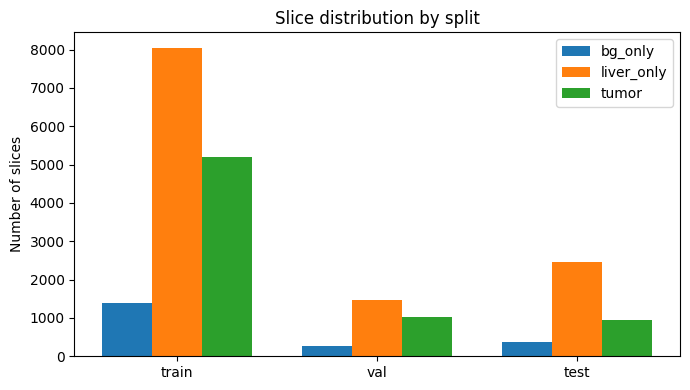

✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/figures/slice_distribution_counts.png


In [ ]:
# =========================
# 6.4 PLOT SLICE-LEVEL IMBALANCE
# =========================
import matplotlib.pyplot as plt
import os

os.makedirs(DIRS["figures"], exist_ok=True)
FIG_DIR = DIRS["figures"]

cats = ["bg_only", "liver_only", "tumor"]

plt.figure(figsize=(7,4))
x = np.arange(len(df_presence["split"]))
width = 0.25

plt.bar(x - width, df_presence["bg_only"], width, label="bg_only")
plt.bar(x,         df_presence["liver_only"], width, label="liver_only")
plt.bar(x + width, df_presence["tumor"], width, label="tumor")

plt.xticks(x, df_presence["split"])
plt.ylabel("Number of slices")
plt.title("Slice distribution by split")
plt.legend()
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "slice_distribution_counts.png")
plt.savefig(out_path, dpi=160, bbox_inches="tight")
plt.show()

print("✅ Saved:", out_path)

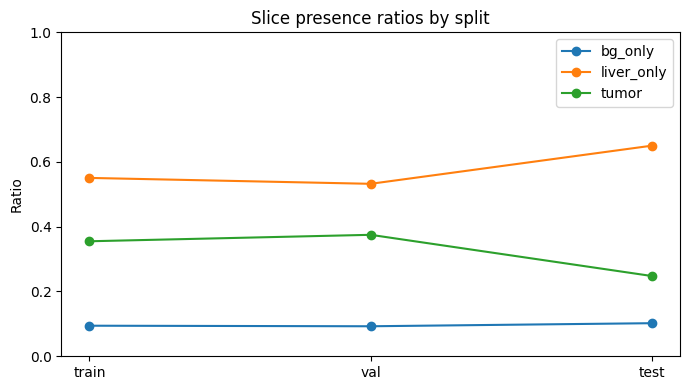

✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/figures/slice_distribution_ratios.png


In [ ]:
# =========================
# 6.5 PLOT SLICE-LEVEL RATIOS
# =========================
plt.figure(figsize=(7,4))

plt.plot(df_presence["split"], df_presence["ratio_bg_only"], marker="o", label="bg_only")
plt.plot(df_presence["split"], df_presence["ratio_liver_only"], marker="o", label="liver_only")
plt.plot(df_presence["split"], df_presence["ratio_tumor"], marker="o", label="tumor")

plt.ylim(0, 1)
plt.ylabel("Ratio")
plt.title("Slice presence ratios by split")
plt.legend()
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "slice_distribution_ratios.png")
plt.savefig(out_path, dpi=160, bbox_inches="tight")
plt.show()

print("✅ Saved:", out_path)

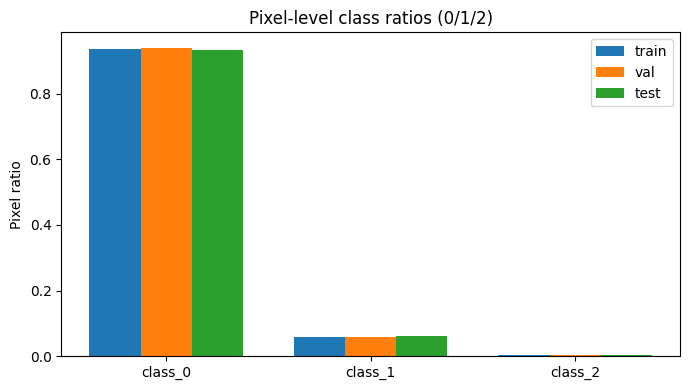

✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/figures/pixel_class_ratios.png


In [ ]:
# =========================
# 6.6 PLOT PIXEL-LEVEL CLASS IMBALANCE
# =========================
plt.figure(figsize=(7,4))

labels = [f"class_{i}" for i in range(NUM_CLASSES)]
x = np.arange(len(labels))
width = 0.25

train_rat = [df_pixels.loc[df_pixels["split"]=="train", f"ratio_c{i}"].values[0] for i in range(NUM_CLASSES)]
val_rat   = [df_pixels.loc[df_pixels["split"]=="val",   f"ratio_c{i}"].values[0] for i in range(NUM_CLASSES)]
test_rat  = [df_pixels.loc[df_pixels["split"]=="test",  f"ratio_c{i}"].values[0] for i in range(NUM_CLASSES)]

plt.bar(x - width, train_rat, width, label="train")
plt.bar(x,         val_rat,   width, label="val")
plt.bar(x + width, test_rat,  width, label="test")

plt.xticks(x, labels)
plt.ylabel("Pixel ratio")
plt.title("Pixel-level class ratios (0/1/2)")
plt.legend()
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "pixel_class_ratios.png")
plt.savefig(out_path, dpi=160, bbox_inches="tight")
plt.show()

print("✅ Saved:", out_path)

In [ ]:
# =========================
# 6.7 SAVE STATS
# =========================
import json, pandas as pd, os

os.makedirs(DIRS["csv"], exist_ok=True)

presence_csv = os.path.join(DIRS["csv"], "slice_presence_stats.csv")
pixels_csv   = os.path.join(DIRS["csv"], "pixel_class_stats.csv")

df_presence.to_csv(presence_csv, index=False)
df_pixels.to_csv(pixels_csv, index=False)

summary = {
    "slice_presence": {
        "train": stats_train,
        "val":   stats_val,
        "test":  stats_test,
    },
    "pixel_distribution": {
        "train": pix_train,
        "val":   pix_val,
        "test":  pix_test,
    },
}

summary_json = os.path.join(DIRS["csv"], "imbalance_summary.json")
with open(summary_json, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

print("✅ Saved:", presence_csv)
print("✅ Saved:", pixels_csv)
print("✅ Saved:", summary_json)

✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv/slice_presence_stats.csv
✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv/pixel_class_stats.csv
✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv/imbalance_summary.json


In [ ]:
# =========================
# 6.8 AUTO INTERPRETATION (REPORT TEXT)
# =========================
def pct(x):
    return f"{x*100:.2f}%"

for split_name, st in [("train", stats_train), ("val", stats_val), ("test", stats_test)]:
    print(f"\n[{split_name.upper()}]")
    print(f"Total slices: {st['N']}")
    print(f"bg_only   : {st['bg_only']} ({pct(st['ratio_bg_only'])})")
    print(f"liver_only: {st['liver_only']} ({pct(st['ratio_liver_only'])})")
    print(f"tumor     : {st['tumor']} ({pct(st['ratio_tumor'])})")

print("\nPixel ratios (train):", [pct(r) for r in pix_train["ratios"]])


[TRAIN]
Total slices: 14613
bg_only   : 1379 (9.44%)
liver_only: 8046 (55.06%)
tumor     : 5188 (35.50%)

[VAL]
Total slices: 2763
bg_only   : 256 (9.27%)
liver_only: 1471 (53.24%)
tumor     : 1036 (37.50%)

[TEST]
Total slices: 3770
bg_only   : 385 (10.21%)
liver_only: 2451 (65.01%)
tumor     : 934 (24.77%)

Pixel ratios (train): ['93.66%', '5.97%', '0.37%']


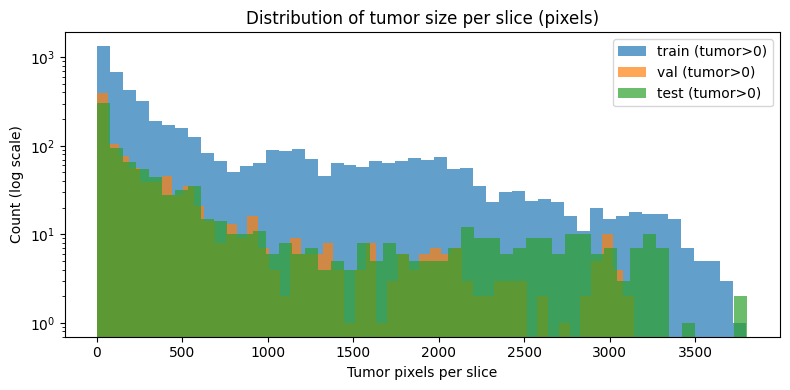

✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/figures/tumor_pixels_hist_log.png


In [ ]:
# =========================
# 6.9 TUMOR PIXELS PER SLICE (HIST, LOG)
# =========================
import numpy as np
import matplotlib.pyplot as plt
import os

def tumor_pixels_per_slice(Y_path, tumor_id=2):
    Y = np.load(Y_path, mmap_mode="r")
    n = Y.shape[0]
    tp = np.zeros(n, dtype=np.int32)
    for i in range(n):
        tp[i] = int(np.count_nonzero(Y[i] == tumor_id))
    return tp

tp_train = tumor_pixels_per_slice(Y_TRAIN_PATH)
tp_val   = tumor_pixels_per_slice(Y_VAL_PATH)
tp_test  = tumor_pixels_per_slice(Y_TEST_PATH)

plt.figure(figsize=(8,4))
plt.hist(tp_train[tp_train>0], bins=50, alpha=0.7, label="train (tumor>0)")
plt.hist(tp_val[tp_val>0], bins=50, alpha=0.7, label="val (tumor>0)")
plt.hist(tp_test[tp_test>0], bins=50, alpha=0.7, label="test (tumor>0)")
plt.yscale("log")
plt.xlabel("Tumor pixels per slice")
plt.ylabel("Count (log scale)")
plt.title("Distribution of tumor size per slice (pixels)")
plt.legend()
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "tumor_pixels_hist_log.png")
plt.savefig(out_path, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Saved:", out_path)

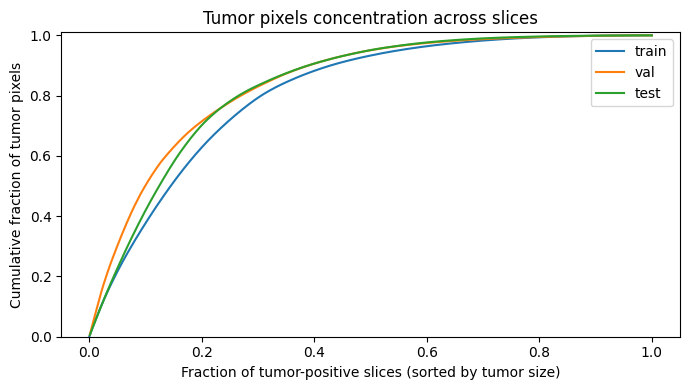

✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/figures/tumor_pixels_cumulative.png


In [ ]:
# =========================
# 6.10 CUMULATIVE TUMOR PIXEL CONTRIBUTION (TOP SLICES)
# =========================
import numpy as np
import matplotlib.pyplot as plt
import os

def cumulative_contrib(tp):
    tp_pos = tp[tp > 0].astype(np.float64)
    if len(tp_pos) == 0:
        return None
    tp_sorted = np.sort(tp_pos)[::-1]
    cum = np.cumsum(tp_sorted) / (tp_sorted.sum() + 1e-12)
    frac_slices = np.arange(1, len(tp_sorted)+1) / len(tp_sorted)
    return frac_slices, cum

plt.figure(figsize=(7,4))
for name, tp in [("train", tp_train), ("val", tp_val), ("test", tp_test)]:
    cc = cumulative_contrib(tp)
    if cc is None:
        continue
    x, y = cc
    plt.plot(x, y, label=name)

plt.xlabel("Fraction of tumor-positive slices (sorted by tumor size)")
plt.ylabel("Cumulative fraction of tumor pixels")
plt.title("Tumor pixels concentration across slices")
plt.ylim(0, 1.01)
plt.legend()
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "tumor_pixels_cumulative.png")
plt.savefig(out_path, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Saved:", out_path)

In [ ]:
# =========================
# 6.11 BUILD SLICE WEIGHTS (HEURISTIC) FOR TRAINING
# =========================
import numpy as np

# weight theo log(1 + tumor_pixels) để tăng xác suất chọn slice có tumor rõ hơn
tp = tp_train.astype(np.float32)
w = np.log1p(tp)

# bg/liver-only vẫn có weight nhỏ để model học biên gan ổn
w = np.where(tp > 0, 1.0 + w, 0.2)

print("weights summary:", {
    "min": float(w.min()),
    "max": float(w.max()),
    "mean": float(w.mean()),
    "p50": float(np.percentile(w, 50)),
    "p90": float(np.percentile(w, 90)),
})

weights summary: {'min': 0.20000000298023224, 'max': 9.241966247558594, 'mean': 2.4251859188079834, 'p50': 0.20000000298023224, 'p90': 7.888368606567383}


# **Mục 7 - Xây dựng Dataset Pipeline**

In [ ]:
# =========================
# 7.0 LOAD NPY (MEMMAP SAFE)
# =========================
import os, numpy as np, tensorflow as tf

NPY_ROOT = os.path.join(DIRS["artifacts"], "npy_2d")
IMG_DIR  = os.path.join(NPY_ROOT, "images")
MSK_DIR  = os.path.join(NPY_ROOT, "masks")

X_TRAIN_PATH = os.path.join(IMG_DIR, "train.npy")
Y_TRAIN_PATH = os.path.join(MSK_DIR, "train.npy")
X_VAL_PATH   = os.path.join(IMG_DIR, "val.npy")
Y_VAL_PATH   = os.path.join(MSK_DIR, "val.npy")
X_TEST_PATH  = os.path.join(IMG_DIR, "test.npy")
Y_TEST_PATH  = os.path.join(MSK_DIR, "test.npy")

# Memmap để không đẩy tất cả vào RAM
X_train = np.load(X_TRAIN_PATH, mmap_mode="r")
Y_train = np.load(Y_TRAIN_PATH, mmap_mode="r")

X_val   = np.load(X_VAL_PATH,   mmap_mode="r")
Y_val   = np.load(Y_VAL_PATH,   mmap_mode="r")

X_test  = np.load(X_TEST_PATH,  mmap_mode="r")
Y_test  = np.load(Y_TEST_PATH,  mmap_mode="r")

print("Loaded (memmap) from:", NPY_ROOT)
print("X_train:", X_train.shape, X_train.dtype, "| Y_train:", Y_train.shape, Y_train.dtype)
print("X_val  :", X_val.shape,   X_val.dtype,   "| Y_val  :", Y_val.shape,   Y_val.dtype)
print("X_test :", X_test.shape,  X_test.dtype,  "| Y_test :", Y_test.shape,  Y_test.dtype)

Loaded (memmap) from: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/artifacts/npy_2d
X_train: (14613, 256, 256, 1) float32 | Y_train: (14613, 256, 256) uint8
X_val  : (2763, 256, 256, 1) float32 | Y_val  : (2763, 256, 256) uint8
X_test : (3770, 256, 256, 1) float32 | Y_test : (3770, 256, 256) uint8


In [ ]:
# =========================
# 7.1 PIPELINE SETTINGS (SAFER CACHE)
# =========================
AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE  = int(BATCH_SIZE) if "BATCH_SIZE" in globals() else 8
USE_CACHE_TRAIN = False              # train có aug -> cache không đáng, dễ phình
USE_CACHE_EVAL  = True               # val/test cache OK
USE_AUG    = True
SHUFFLE_BUF = 4096

print("BATCH_SIZE:", BATCH_SIZE)
print("USE_CACHE_TRAIN:", USE_CACHE_TRAIN)
print("USE_CACHE_EVAL :", USE_CACHE_EVAL)
print("USE_AUG   :", USE_AUG)
print("SHUFFLE_BUF:", SHUFFLE_BUF)

BATCH_SIZE: 8
USE_CACHE_TRAIN: False
USE_CACHE_EVAL : True
USE_AUG   : True
SHUFFLE_BUF: 4096


In [ ]:
# =========================
# 7.2 PREPROCESS
# =========================
@tf.function
def preprocess_xy(x, y):
    # x: (H,W,1) float32 in [0,1]
    x = tf.cast(x, tf.float32)
    x = tf.clip_by_value(x, 0.0, 1.0)

    # y: (H,W) int32 {0,1,2}
    y = tf.cast(y, tf.int32)
    return x, y

In [ ]:
# =========================
# 7.2b PIXEL-WISE CLASS WEIGHTS (FOR IMBALANCE)
# =========================
import tensorflow as tf

# heuristic: tumor nặng hơn nhiều do ~0.3–0.5% pixels
W_BG    = 0.2
W_LIVER = 1.0
W_TUMOR = 8.0

CLASS_WEIGHTS = tf.constant([W_BG, W_LIVER, W_TUMOR], dtype=tf.float32)
print("CLASS_WEIGHTS:", CLASS_WEIGHTS.numpy())

CLASS_WEIGHTS: [0.2 1.  8. ]


In [ ]:
# =========================
# 7.2c BUILD SAMPLE_WEIGHT MAP PER PIXEL
# =========================
@tf.function
def add_sample_weight(x, y):
    # y: (H,W) int32
    w = tf.gather(CLASS_WEIGHTS, y)  # (H,W)
    return x, y, w

In [ ]:
# =========================
# 7.3 AUGMENTATION
# =========================
@tf.function
def augment_sync(x, y):
    # y expand to (H,W,1) để dùng tf.image
    y1 = y[..., tf.newaxis]

    # flip LR
    do_lr = tf.random.uniform(()) > 0.5
    x = tf.cond(do_lr, lambda: tf.image.flip_left_right(x), lambda: x)
    y1 = tf.cond(do_lr, lambda: tf.image.flip_left_right(y1), lambda: y1)

    # flip UD
    do_ud = tf.random.uniform(()) > 0.5
    x = tf.cond(do_ud, lambda: tf.image.flip_up_down(x), lambda: x)
    y1 = tf.cond(do_ud, lambda: tf.image.flip_up_down(y1), lambda: y1)

    # rotate k*90
    k = tf.random.uniform((), 0, 4, dtype=tf.int32)
    x = tf.image.rot90(x, k)
    y1 = tf.image.rot90(y1, k)

    return x, tf.squeeze(y1, axis=-1)

@tf.function
def augment_ct_only(x, y):
    # gaussian noise nhẹ
    do_noise = tf.random.uniform(()) > 0.5
    def add_noise():
        noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=0.02)
        return tf.clip_by_value(x + noise, 0.0, 1.0)
    x = tf.cond(do_noise, add_noise, lambda: x)

    # contrast nhẹ
    do_contrast = tf.random.uniform(()) > 0.5
    def add_contrast():
        xc = tf.image.random_contrast(x, lower=0.90, upper=1.10)
        return tf.clip_by_value(xc, 0.0, 1.0)
    x = tf.cond(do_contrast, add_contrast, lambda: x)

    return x, y

In [ ]:
# =========================
# 7.4 MAKE DATASET (WITH OPTIONAL WEIGHTS)
# =========================
def make_dataset(X, Y, training=False, use_weights=True):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))

    if training:
        ds = ds.shuffle(buffer_size=min(len(X), SHUFFLE_BUF),
                        seed=SEED, reshuffle_each_iteration=True)

    ds = ds.map(preprocess_xy, num_parallel_calls=AUTOTUNE)

    # cache: tách train vs eval
    if (training and USE_CACHE_TRAIN) or ((not training) and USE_CACHE_EVAL):
        ds = ds.cache()

    if training and USE_AUG:
        ds = ds.map(augment_sync, num_parallel_calls=AUTOTUNE)
        ds = ds.map(augment_ct_only, num_parallel_calls=AUTOTUNE)

    if use_weights:
        ds = ds.map(add_sample_weight, num_parallel_calls=AUTOTUNE)  # (x,y,w)

    ds = ds.batch(BATCH_SIZE, drop_remainder=training)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, Y_train, training=True,  use_weights=True)
val_ds   = make_dataset(X_val,   Y_val,   training=False, use_weights=True)
test_ds  = make_dataset(X_test,  Y_test,  training=False, use_weights=True)

print("train_ds:", train_ds.element_spec)
print("val_ds  :", val_ds.element_spec)
print("test_ds :", test_ds.element_spec)

train_ds: (TensorSpec(shape=(8, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(8, 256, 256), dtype=tf.int32, name=None), TensorSpec(shape=(8, 256, 256), dtype=tf.float32, name=None))
val_ds  : (TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.float32, name=None))
test_ds : (TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.float32, name=None))


In [ ]:
# =========================
# 7.5 SANITY CHECK BATCH (X,Y,W)
# =========================
bx, by, bw = next(iter(train_ds))
print("Batch X:", bx.shape, bx.dtype)
print("Batch Y:", by.shape, by.dtype)
print("Batch W:", bw.shape, bw.dtype, "| w(min/max):", float(tf.reduce_min(bw)), float(tf.reduce_max(bw)))

uniq = tf.unique(tf.reshape(by, [-1]))[0]
print("Unique labels in batch:", uniq.numpy())

Batch X: (8, 256, 256, 1) <dtype: 'float32'>
Batch Y: (8, 256, 256) <dtype: 'int32'>
Batch W: (8, 256, 256) <dtype: 'float32'> | w(min/max): 0.20000000298023224 8.0
Unique labels in batch: [0 1 2]


Unique labels in this batch: [0 1 2]


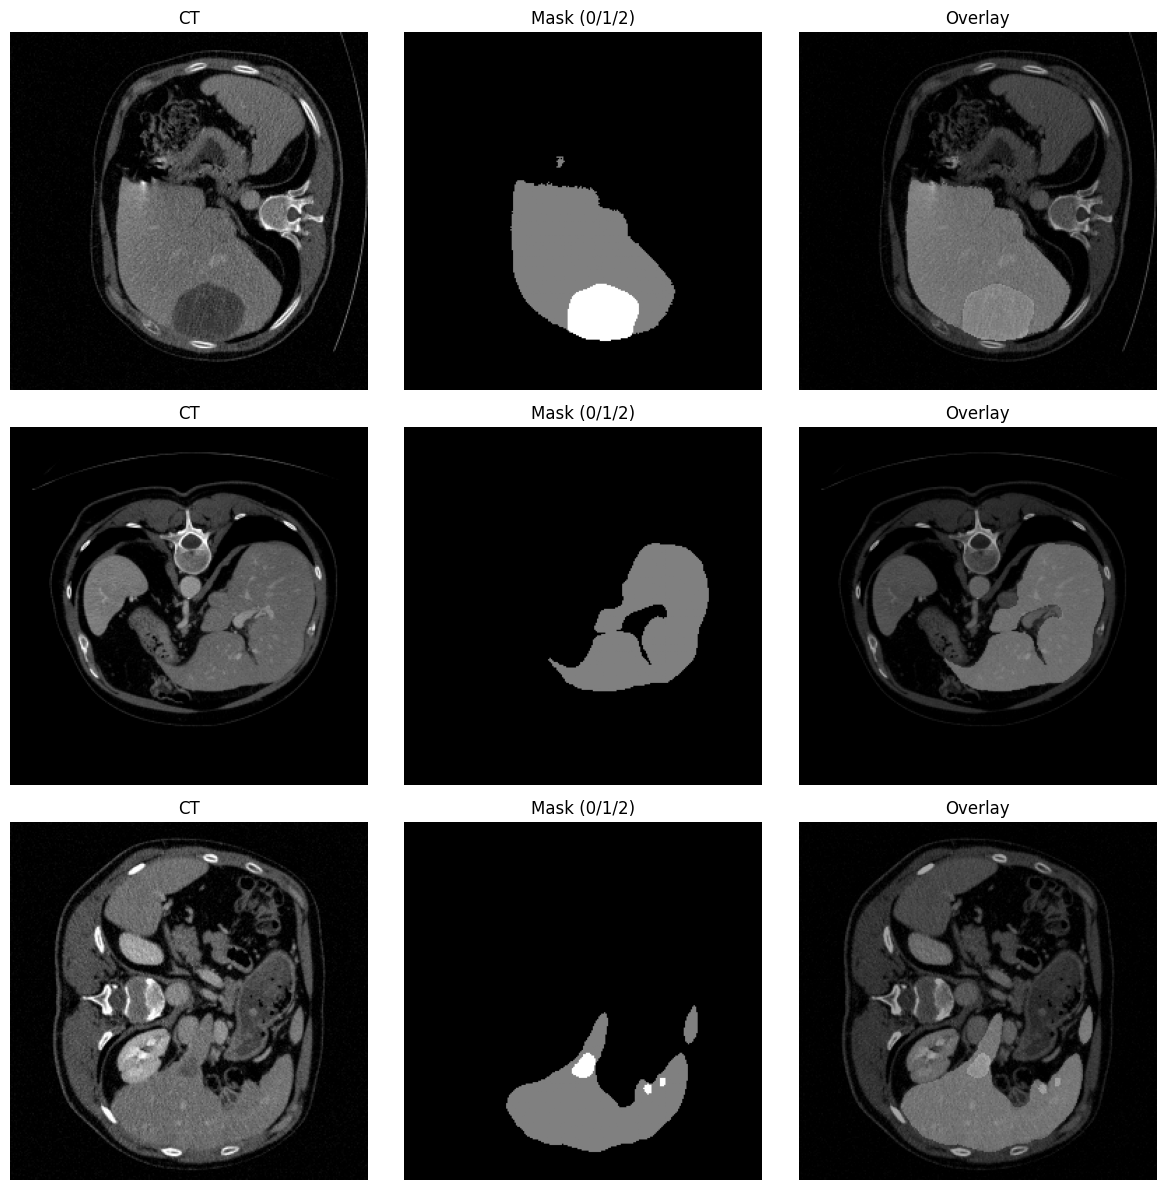

In [ ]:
# =========================
# 7.6 VISUALIZE AUGMENTATION (X,Y,W)
# =========================
import matplotlib.pyplot as plt
import numpy as np

bx, by, bw = next(iter(train_ds))
bx = bx.numpy()
by = by.numpy()

print("Unique labels in this batch:", np.unique(by))

n_show = 3
plt.figure(figsize=(12, 4*n_show))
for i in range(n_show):
    img = bx[i, :, :, 0]
    msk = by[i, :, :]

    ax1 = plt.subplot(n_show, 3, i*3 + 1)
    ax1.imshow(img, cmap="gray"); ax1.set_title("CT"); ax1.axis("off")

    ax2 = plt.subplot(n_show, 3, i*3 + 2)
    ax2.imshow(msk, vmin=0, vmax=2); ax2.set_title("Mask (0/1/2)"); ax2.axis("off")

    ax3 = plt.subplot(n_show, 3, i*3 + 3)
    ax3.imshow(img, cmap="gray")
    ax3.imshow(msk, alpha=0.35, vmin=0, vmax=2)
    ax3.set_title("Overlay"); ax3.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# =========================
# 7.7 CHECK TUMOR PIXELS PER BATCH (MORE INFORMATIVE)
# =========================
import numpy as np
import tensorflow as tf

def tumor_pixels_per_batch(ds, n_batches=200):
    vals = []
    for (x, y, w) in ds.take(n_batches):
        vals.append(int(tf.reduce_sum(tf.cast(y == 2, tf.int32)).numpy()))
    vals = np.array(vals)
    print(f"Checked {len(vals)} batches")
    print("Tumor pixels per batch: mean=", float(vals.mean()), "median=", float(np.median(vals)),
          "min=", int(vals.min()), "max=", int(vals.max()))
    print("Batches with 0 tumor pixels:", int((vals==0).sum()), f"({(vals==0).mean()*100:.1f}%)")

tumor_pixels_per_batch(train_ds, n_batches=200)

Checked 200 batches
Tumor pixels per batch: mean= 2413.73 median= 2164.5 min= 0 max= 8756
Batches with 0 tumor pixels: 2 (1.0%)


# **Mục 8 – Xây dựng mô hình UNet_Baseline và UNet_TxBottleneck (U-Net cơ bản + Transformer ở bottleneck)**

*   Dùng chung INPUT_SHAPE, NUM_CLASSES, BASE_FILTERS
*   Transformer hoạt động trên feature map bottleneck dạng (B,H,W,C) → flatten (B,HW,C) → MHA → FFN → reshape lại

In [ ]:
# =========================
# 8.0 MODEL CONFIG
# =========================
import tensorflow as tf
from tensorflow.keras import layers, models

INPUT_SHAPE  = (IMG_SIZE, IMG_SIZE, 1)
NUM_CLASSES  = int(NUM_CLASSES) if "NUM_CLASSES" in globals() else 3
BASE_FILTERS = int(BASE_FILTERS) if "BASE_FILTERS" in globals() else 32

print("INPUT_SHAPE :", INPUT_SHAPE)
print("NUM_CLASSES :", NUM_CLASSES)
print("BASE_FILTERS:", BASE_FILTERS)

INPUT_SHAPE : (256, 256, 1)
NUM_CLASSES : 3
BASE_FILTERS: 32


In [ ]:
# =========================
# 8.1 UNET BLOCKS
# =========================
def conv_block(x, filters, name):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False, name=f"{name}_conv1")(x)
    x = layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = layers.ReLU(name=f"{name}_relu1")(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False, name=f"{name}_conv2")(x)
    x = layers.BatchNormalization(name=f"{name}_bn2")(x)
    x = layers.ReLU(name=f"{name}_relu2")(x)
    return x

In [ ]:
# =========================
# 8.2 UNET BASELINE
# =========================
def build_unet_baseline(input_shape=(256,256,1), num_classes=3, base_filters=32):
    inputs = layers.Input(shape=input_shape, name="input")

    # Encoder
    c1 = conv_block(inputs, base_filters,   name="enc1")
    p1 = layers.MaxPooling2D(name="pool1")(c1)

    c2 = conv_block(p1, base_filters*2,     name="enc2")
    p2 = layers.MaxPooling2D(name="pool2")(c2)

    c3 = conv_block(p2, base_filters*4,     name="enc3")
    p3 = layers.MaxPooling2D(name="pool3")(c3)

    c4 = conv_block(p3, base_filters*8,     name="enc4")
    p4 = layers.MaxPooling2D(name="pool4")(c4)

    # Bottleneck
    bn = conv_block(p4, base_filters*16,    name="bottleneck")

    # Decoder
    u4 = layers.UpSampling2D(name="up4")(bn)
    u4 = layers.Concatenate(name="cat4")([u4, c4])
    d4 = conv_block(u4, base_filters*8,     name="dec4")

    u3 = layers.UpSampling2D(name="up3")(d4)
    u3 = layers.Concatenate(name="cat3")([u3, c3])
    d3 = conv_block(u3, base_filters*4,     name="dec3")

    u2 = layers.UpSampling2D(name="up2")(d3)
    u2 = layers.Concatenate(name="cat2")([u2, c2])
    d2 = conv_block(u2, base_filters*2,     name="dec2")

    u1 = layers.UpSampling2D(name="up1")(d2)
    u1 = layers.Concatenate(name="cat1")([u1, c1])
    d1 = conv_block(u1, base_filters,       name="dec1")

    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax", name="softmax")(d1)

    return models.Model(inputs, outputs, name="UNet_Baseline")


model_unet = build_unet_baseline(INPUT_SHAPE, NUM_CLASSES, BASE_FILTERS)
print("✅ Built:", model_unet.name)

✅ Built: UNet_Baseline


In [ ]:
# =========================
# 8.3 BOTTLENECK TRANSFORMER (WITH POS EMB)
# =========================
@tf.keras.utils.register_keras_serializable(package="LiTS")
class BottleneckTransformer(layers.Layer):
    """
    MHSA + FFN on bottleneck feature map with learnable positional embedding.
    Input:  (B,H,W,C)
    Output: (B,H,W,C)
    """
    def __init__(self, num_heads=8, key_dim=64, mlp_dim=512, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = int(num_heads)
        self.key_dim   = int(key_dim)
        self.mlp_dim   = int(mlp_dim)
        self.dropout   = float(dropout)

        self.ln1 = layers.LayerNormalization(epsilon=1e-6, name="ln1")
        self.mha = layers.MultiHeadAttention(
            num_heads=self.num_heads, key_dim=self.key_dim, dropout=self.dropout, name="mha"
        )
        self.add1 = layers.Add(name="add1")

        self.ln2  = layers.LayerNormalization(epsilon=1e-6, name="ln2")
        self.ffn1 = layers.Dense(self.mlp_dim, activation="gelu", name="ffn1")
        self.drop = layers.Dropout(self.dropout, name="drop")
        self.ffn2 = None
        self.add2 = layers.Add(name="add2")

        self.pos_emb = None  # created in build()

    def build(self, input_shape):
        c = int(input_shape[-1])
        self.ffn2 = layers.Dense(c, name="ffn2")

        # learnable position embedding for sequence length HW
        # HW is dynamic at runtime, so we create a variable for max HW based on static H,W if available.
        h = int(input_shape[1]) if input_shape[1] is not None else None
        w = int(input_shape[2]) if input_shape[2] is not None else None
        if h is None or w is None:
            # fallback: create later in call if needed (rare in your fixed IMG_SIZE pipeline)
            self.pos_emb = None
        else:
            hw = h * w
            self.pos_emb = self.add_weight(
                name="pos_emb",
                shape=(1, hw, c),
                initializer="zeros",
                trainable=True
            )

        super().build(input_shape)

    def call(self, x, training=None):
        b = tf.shape(x)[0]
        h = tf.shape(x)[1]
        w = tf.shape(x)[2]
        c = x.shape[-1]

        x_flat = tf.reshape(x, [b, h*w, c])  # (B, HW, C)

        # add positional embedding if available (fixed IMG_SIZE -> available)
        if self.pos_emb is not None:
            x_flat = x_flat + self.pos_emb
        # else: omit (fallback)

        y = self.ln1(x_flat)
        y = self.mha(y, y, training=training)
        x_flat = self.add1([x_flat, y])

        y = self.ln2(x_flat)
        y = self.ffn1(y)
        y = self.drop(y, training=training)
        y = self.ffn2(y)
        x_flat = self.add2([x_flat, y])

        return tf.reshape(x_flat, [b, h, w, c])

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
            "mlp_dim": self.mlp_dim,
            "dropout": self.dropout,
        })
        return cfg

print("✅ BottleneckTransformer (pos-emb) ready")


✅ BottleneckTransformer (pos-emb) ready


In [ ]:
# =========================
# 8.4 UNET + TRANSFORMER BOTTLENECK
# =========================
def build_unet_txbottleneck(input_shape=(256,256,1), num_classes=3, base_filters=32,
                            num_heads=8, key_dim=64, mlp_dim=512, dropout=0.1):
    inputs = layers.Input(shape=input_shape, name="input")

    # Encoder
    c1 = conv_block(inputs, base_filters,   name="enc1"); p1 = layers.MaxPooling2D(name="pool1")(c1)
    c2 = conv_block(p1, base_filters*2,     name="enc2"); p2 = layers.MaxPooling2D(name="pool2")(c2)
    c3 = conv_block(p2, base_filters*4,     name="enc3"); p3 = layers.MaxPooling2D(name="pool3")(c3)
    c4 = conv_block(p3, base_filters*8,     name="enc4"); p4 = layers.MaxPooling2D(name="pool4")(c4)

    # Bottleneck conv
    bn = conv_block(p4, base_filters*16,    name="bottleneck_conv")

    # Transformer at bottleneck
    bn = BottleneckTransformer(
        num_heads=num_heads,
        key_dim=key_dim,
        mlp_dim=mlp_dim,
        dropout=dropout,
        name="bottleneck_tx"
    )(bn)

    # Decoder
    u4 = layers.UpSampling2D(name="up4")(bn); u4 = layers.Concatenate(name="cat4")([u4, c4]); d4 = conv_block(u4, base_filters*8, name="dec4")
    u3 = layers.UpSampling2D(name="up3")(d4); u3 = layers.Concatenate(name="cat3")([u3, c3]); d3 = conv_block(u3, base_filters*4, name="dec3")
    u2 = layers.UpSampling2D(name="up2")(d3); u2 = layers.Concatenate(name="cat2")([u2, c2]); d2 = conv_block(u2, base_filters*2, name="dec2")
    u1 = layers.UpSampling2D(name="up1")(d2); u1 = layers.Concatenate(name="cat1")([u1, c1]); d1 = conv_block(u1, base_filters,   name="dec1")

    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax", name="softmax")(d1)

    return models.Model(inputs, outputs, name="UNet_TxBottleneck")


model_unet_tx = build_unet_txbottleneck(
    INPUT_SHAPE, NUM_CLASSES, BASE_FILTERS,
    num_heads=4, key_dim=64, mlp_dim=512, dropout=0.1
)
print("✅ Built:", model_unet_tx.name)

✅ Built: UNet_TxBottleneck


In [ ]:
# =========================
# 8.5 SUMMARY + PARAMS
# =========================
def count_params(m):
    return int(m.count_params())

print("UNet_Baseline params    :", count_params(model_unet))
print("UNet_TxBottleneck params:", count_params(model_unet_tx))

# (tuỳ chọn) xem summary
# model_unet.summary()
# model_unet_tx.summary()

UNet_Baseline params    : 7854979
UNet_TxBottleneck params: 9038979


In [ ]:
model_unet.summary()

Model: "UNet_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv1 (Conv2D) │ (None, 256, 256,  │        288 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_bn1            │ (None, 256, 256,  │        128 │ enc1_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_relu1 (ReLU)   │ (None, 256, 256,  │          0 │ enc1_bn1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv2 (Conv2D) │ (None, 256, 256,  │      9,216 │ enc1_relu1[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_bn2            │ (None, 256, 256,  │        128 │ enc1_conv2[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_relu2 (ReLU)   │ (None, 256, 256,  │          0 │ enc1_bn2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 128, 128,  │          0 │ enc1_relu2[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv1 (Conv2D) │ (None, 128, 128,  │     18,432 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_bn1            │ (None, 128, 128,  │        256 │ enc2_conv1[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_relu1 (ReLU)   │ (None, 128, 128,  │          0 │ enc2_bn1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv2 (Conv2D) │ (None, 128, 128,  │     36,864 │ enc2_relu1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_bn2            │ (None, 128, 128,  │        256 │ enc2_conv2[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_relu2 (ReLU)   │ (None, 128, 128,  │          0 │ enc2_bn2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 64, 64,    │          0 │ enc2_relu2[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc3_conv1 (Conv2D) │ (None, 64, 64,    │     73,728 │ pool2[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc3_bn1            │ (None, 64, 64,    │        512 │ enc3_conv1[0][0]

 Total params: 7,854,979 (29.96 MB)

 Trainable params: 7,849,091 (29.94 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
model_unet_tx.summary()

Model: "UNet_TxBottleneck"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv1 (Conv2D) │ (None, 256, 256,  │        288 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_bn1            │ (None, 256, 256,  │        128 │ enc1_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_relu1 (ReLU)   │ (None, 256, 256,  │          0 │ enc1_bn1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv2 (Conv2D) │ (None, 256, 256,  │      9,216 │ enc1_relu1[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_bn2            │ (None, 256, 256,  │        128 │ enc1_conv2[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_relu2 (ReLU)   │ (None, 256, 256,  │          0 │ enc1_bn2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 128, 128,  │          0 │ enc1_relu2[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv1 (Conv2D) │ (None, 128, 128,  │     18,432 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_bn1            │ (None, 128, 128,  │        256 │ enc2_conv1[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_relu1 (ReLU)   │ (None, 128, 128,  │          0 │ enc2_bn1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv2 (Conv2D) │ (None, 128, 128,  │     36,864 │ enc2_relu1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_bn2            │ (None, 128, 128,  │        256 │ enc2_conv2[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_relu2 (ReLU)   │ (None, 128, 128,  │          0 │ enc2_bn2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 64, 64,    │          0 │ enc2_relu2[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc3_conv1 (Conv2D) │ (None, 64, 64,    │     73,728 │ pool2[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc3_bn1            │ (None, 64, 64,    │        512 │ enc3_conv1[0][0]

 Total params: 9,038,979 (34.48 MB)

 Trainable params: 9,033,091 (34.46 MB)

 Non-trainable params: 5,888 (23.00 KB)

# **Mục 9 - Train 2 model (Baseline + TxBottleneck)**

In [ ]:
# =========================================================
# MỤC 9 — TRAIN 2 MODELS + SAVE CSV + CHECKPOINT + COMPARE
# =========================================================
import os, time, json
import numpy as np
import pandas as pd
import tensorflow as tf

assert "DIRS" in globals(), "DIRS chưa có (phải chạy Mục 0)."
assert "train_ds" in globals() and "val_ds" in globals() and "test_ds" in globals(), "Chưa có tf.data datasets (Mục 7)."
assert "model_unet" in globals() and "model_unet_tx" in globals(), "Chưa có 2 model (Mục 8)."

# ---- Train hyperparams (bạn có thể override trước khi chạy cell này)
EPOCHS = int(globals().get("EPOCHS", 30))
LR     = float(globals().get("LR", 1e-4))

# ---- Output dirs
os.makedirs(DIRS["models"], exist_ok=True)
os.makedirs(DIRS["csv"],    exist_ok=True)
os.makedirs(DIRS["logs"],   exist_ok=True)

TB_LOGDIR = os.path.join(DIRS["logs"], "tensorboard")
os.makedirs(TB_LOGDIR, exist_ok=True)

print("EPOCHS:", EPOCHS, "| LR:", LR)
print("TB_LOGDIR:", TB_LOGDIR)
print("DIRS[csv]:", DIRS["csv"])
print("DIRS[models]:", DIRS["models"])

EPOCHS: 30 | LR: 0.0001
TB_LOGDIR: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/logs/tensorboard
DIRS[csv]: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv
DIRS[models]: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/models


In [ ]:
# =========================
# 9.1 LOSS + METRICS
# =========================
SMOOTH = 1e-6

def dice_per_class(y_true, y_pred, class_id: int):
    # y_true: (B,H,W) int32
    # y_pred: (B,H,W,C) softmax float32
    y_true_c = tf.cast(tf.equal(tf.cast(y_true, tf.int32), class_id), tf.float32)
    y_pred_c = tf.cast(y_pred[..., class_id], tf.float32)

    inter = tf.reduce_sum(y_true_c * y_pred_c)
    denom = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c)
    return (2.0 * inter + SMOOTH) / (denom + SMOOTH)

def iou_per_class(y_true, y_pred, class_id: int):
    y_true_c = tf.cast(tf.equal(tf.cast(y_true, tf.int32), class_id), tf.float32)
    y_pred_c = tf.cast(y_pred[..., class_id], tf.float32)

    inter = tf.reduce_sum(y_true_c * y_pred_c)
    union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) - inter
    return (inter + SMOOTH) / (union + SMOOTH)

def dice_liver(y_true, y_pred): return dice_per_class(y_true, y_pred, 1)
def dice_tumor(y_true, y_pred): return dice_per_class(y_true, y_pred, 2)
def dice_mean_no_bg(y_true, y_pred): return 0.5 * (dice_liver(y_true, y_pred) + dice_tumor(y_true, y_pred))

def iou_liver(y_true, y_pred): return iou_per_class(y_true, y_pred, 1)
def iou_tumor(y_true, y_pred): return iou_per_class(y_true, y_pred, 2)
def iou_mean_no_bg(y_true, y_pred): return 0.5 * (iou_liver(y_true, y_pred) + iou_tumor(y_true, y_pred))

loss_ce = tf.keras.losses.SparseCategoricalCrossentropy()

def dice_loss_no_bg(y_true, y_pred):
    return 1.0 - dice_mean_no_bg(y_true, y_pred)

# Không dùng lambda: định nghĩa hàm loss cụ thể cho alpha=0.5
def loss_ce_dice_alpha05(y_true, y_pred):
    ce = loss_ce(y_true, y_pred)
    dl = dice_loss_no_bg(y_true, y_pred)
    return 0.5 * ce + 0.5 * dl

METRICS = [
    "accuracy",
    dice_liver,
    dice_tumor,
    dice_mean_no_bg,
    iou_liver,
    iou_tumor,
    iou_mean_no_bg,
]

print("✅ Loss & Metrics ready.")
print("Metrics:", [m if isinstance(m, str) else m.__name__ for m in METRICS])

✅ Loss & Metrics ready.
Metrics: ['accuracy', 'dice_liver', 'dice_tumor', 'dice_mean_no_bg', 'iou_liver', 'iou_tumor', 'iou_mean_no_bg']


In [ ]:
# =========================
# 9.2 CALLBACKS (PER MODEL)
# =========================
import psutil
import subprocess

class ResourceLogger(tf.keras.callbacks.Callback):
    def __init__(self, tag=""):
        super().__init__()
        self.tag = tag

    def _get_vram_mb(self):
        try:
            out = subprocess.check_output(
                ["nvidia-smi", "--query-gpu=memory.used", "--format=csv,noheader,nounits"]
            ).decode().strip()
            return int(out.splitlines()[0])
        except:
            return None

    def on_epoch_end(self, epoch, logs=None):
        ram_mb = psutil.virtual_memory().used // (1024**2)
        vram_mb = self._get_vram_mb()
        vram_str = "NA" if vram_mb is None else str(vram_mb)
        print(f"[Resource{self.tag}] epoch={epoch+1} | RAM={ram_mb}MB | VRAM={vram_str}MB")

class EpochTimer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.t0 = time.time()
    def on_epoch_end(self, epoch, logs=None):
        dt = time.time() - self.t0
        self.epoch_times.append(dt)
        print(f"[Time] epoch={epoch+1} took {dt:.2f}s")

def build_callbacks(model_name: str):
    ckpt_path = os.path.join(DIRS["models"], f"{model_name}_best.keras")

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path,
        monitor="val_dice_mean_no_bg",
        mode="max",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    earlystop_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_dice_mean_no_bg",
        mode="max",
        patience=6,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_dice_mean_no_bg",
        mode="max",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )

    tensorboard_cb = tf.keras.callbacks.TensorBoard(
        log_dir=os.path.join(TB_LOGDIR, model_name),
        histogram_freq=0,
        write_graph=False,
        update_freq="epoch"
    )

    # tag để phân biệt log
    resource_cb = ResourceLogger(tag=f":{model_name}")
    timer_cb = EpochTimer()

    cbs = [checkpoint_cb, earlystop_cb, reduce_lr_cb, resource_cb, timer_cb, tensorboard_cb]
    return cbs, ckpt_path, timer_cb

print("✅ Callback builder ready.")

✅ Callback builder ready.


In [ ]:
# =========================
# 9.3 TRAIN HELPER
# =========================
def train_one_model(model: tf.keras.Model, model_tag: str):
    print("\n" + "="*70)
    print(f"TRAINING: {model_tag}")
    print("="*70)

    opt = tf.keras.optimizers.Adam(learning_rate=LR)

    # Compile (NO lambda)
    model.compile(
        optimizer=opt,
        loss=loss_ce_dice_alpha05,
        metrics=METRICS
    )

    # Callbacks (per model)
    callbacks, ckpt_path, timer_cb = build_callbacks(model_tag)
    print("Checkpoint:", ckpt_path)

    # Fit
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    # Build history df
    hist_df = pd.DataFrame(history.history)

    # add timing (guard length)
    epoch_times = getattr(timer_cb, "epoch_times", [])
    if len(epoch_times) == len(hist_df):
        hist_df["epoch_time_sec"] = np.array(epoch_times, dtype=np.float32)
        steps_per_epoch = int(tf.data.experimental.cardinality(train_ds).numpy())
        hist_df["steps_per_sec"] = steps_per_epoch / hist_df["epoch_time_sec"].values
    else:
        hist_df["epoch_time_sec"] = np.nan
        hist_df["steps_per_sec"] = np.nan

    # Save history
    csv_path = os.path.join(DIRS["csv"], f"history_{model_tag}.csv")
    json_path = os.path.join(DIRS["csv"], f"history_{model_tag}.json")
    hist_df.to_csv(csv_path, index=False)
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(hist_df.to_dict(orient="list"), f, ensure_ascii=False, indent=2)

    print("✅ Saved history CSV :", csv_path)
    print("✅ Saved history JSON:", json_path)

    return {
        "model_tag": model_tag,
        "ckpt_path": ckpt_path,
        "history": history,
        "hist_df": hist_df,
    }

print("✅ train_one_model ready.")

✅ train_one_model ready.


In [ ]:
# KIỂM TRA KERNAL
assert "loss_ce_dice_alpha05" in globals()
assert "train_ds" in globals()
assert "val_ds" in globals()
assert "model_unet" in globals()
assert "model_unet_tx" in globals()

In [ ]:
# KIỂM TRA HÀM LOSS ĐÃ ĐỨNG TÊN
print("Has loss_ce_dice_alpha05:", "loss_ce_dice_alpha05" in globals())
print("loss_ce_dice_alpha05:", loss_ce_dice_alpha05 if "loss_ce_dice_alpha05" in globals() else None)

Has loss_ce_dice_alpha05: True
loss_ce_dice_alpha05: <function loss_ce_dice_alpha05 at 0x7e12e022ec00>


In [ ]:
# =========================
# 9.4 TRAIN TWO MODELS
# =========================
train_out_baseline = train_one_model(model_unet,    "UNet_Baseline")
train_out_tx       = train_one_model(model_unet_tx, "UNet_TxBottleneck")


TRAINING: UNet_Baseline
Checkpoint: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/models/UNet_Baseline_best.keras
Epoch 1/30
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9473 - dice_liver: 0.6258 - dice_mean_no_bg: 0.3449 - dice_tumor: 0.0640 - iou_liver: 0.4748 - iou_mean_no_bg: 0.2554 - iou_tumor: 0.0360 - loss: 0.1229
Epoch 1: val_dice_mean_no_bg improved from -inf to 0.41043, saving model to /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/models/UNet_Baseline_best.keras
[Resource:UNet_Baseline] epoch=1 | RAM=17876MB | VRAM=16599MB
[Time] epoch=1 took 235.35s
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 235s 120ms/step - accuracy: 0.9473 - dice_liver: 0.6259 - dice_mean_no_bg: 0.3449 - dice_tu

In [ ]:
# =========================
# 9.5 EVALUATE BEST ON TEST (PER MODEL)
# =========================
custom_objs = {
    "dice_liver": dice_liver,
    "dice_tumor": dice_tumor,
    "dice_mean_no_bg": dice_mean_no_bg,
    "iou_liver": iou_liver,
    "iou_tumor": iou_tumor,
    "iou_mean_no_bg": iou_mean_no_bg,
    "loss_ce_dice_alpha05": loss_ce_dice_alpha05,
}

# Nếu có layer transformer
if "BottleneckTransformer" in globals():
    custom_objs["BottleneckTransformer"] = BottleneckTransformer

def eval_best(ckpt_path: str, model_tag: str):
    m = tf.keras.models.load_model(ckpt_path, custom_objects=custom_objs, compile=False)
    m.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss_ce_dice_alpha05, metrics=METRICS)

    d = m.evaluate(test_ds, verbose=1, return_dict=True)  # <-- quan trọng
    d = {k: float(v) for k, v in d.items()}
    d["model_tag"] = model_tag
    return d

rows = []
rows.append(eval_best(train_out_baseline["ckpt_path"], "UNet_Baseline"))
rows.append(eval_best(train_out_tx["ckpt_path"],       "UNet_TxBottleneck"))

df_test_cmp = pd.DataFrame(rows).set_index("model_tag")

test_csv  = os.path.join(DIRS["csv"], "test_metrics_compare.csv")
test_json = os.path.join(DIRS["csv"], "test_metrics_compare.json")

df_test_cmp.to_csv(test_csv)
with open(test_json, "w", encoding="utf-8") as f:
    json.dump(df_test_cmp.reset_index().to_dict(orient="records"), f, ensure_ascii=False, indent=2)

print("Saved compare CSV :", test_csv)
print("Saved compare JSON:", test_json)

df_test_cmp

472/472 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9921 - dice_liver: 0.7992 - dice_mean_no_bg: 0.4583 - dice_tumor: 0.1174 - iou_liver: 0.7431 - iou_mean_no_bg: 0.4167 - iou_tumor: 0.0903 - loss: 0.0753
472/472 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9925 - dice_liver: 0.8256 - dice_mean_no_bg: 0.4658 - dice_tumor: 0.1061 - iou_liver: 0.7727 - iou_mean_no_bg: 0.4265 - iou_tumor: 0.0803 - loss: 0.0750
Saved compare CSV : /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv/test_metrics_compare.csv
Saved compare JSON: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv/test_metrics_compare.json


accuracy  dice_liver  dice_mean_no_bg  dice_tumor  \
model_tag                                                              
UNet_Baseline      0.992318    0.810476         0.453021    0.095567   
UNet_TxBottleneck  0.992441    0.837338         0.458054    0.078770   

                   iou_liver  iou_mean_no_bg  iou_tumor      loss  
model_tag                                                          
UNet_Baseline       0.755945        0.414191   0.072438  0.078477  
UNet_TxBottleneck   0.787675        0.423075   0.058476  0.081028

In [ ]:
# =========================
# 9.6 COMPARISON TABLE (DELTA)
# =========================
cols_want = []
for c in ["loss", "accuracy", "dice_mean_no_bg", "dice_tumor", "dice_liver", "iou_mean_no_bg", "iou_tumor", "iou_liver"]:
    if c in df_test_cmp.columns:
        cols_want.append(c)

cmp_main = df_test_cmp[cols_want].copy()

if "UNet_Baseline" in cmp_main.index and "UNet_TxBottleneck" in cmp_main.index:
    delta = (cmp_main.loc["UNet_TxBottleneck"] - cmp_main.loc["UNet_Baseline"]).to_frame("TxMinusBase").T
    display(cmp_main)
    display(delta)
else:
    display(cmp_main)
    print("⚠️ Không đủ 2 model trong index để tính delta.")

loss  accuracy  dice_mean_no_bg  dice_tumor  \
model_tag                                                            
UNet_Baseline      0.078477  0.992318         0.453021    0.095567   
UNet_TxBottleneck  0.081028  0.992441         0.458054    0.078770   

                   dice_liver  iou_mean_no_bg  iou_tumor  iou_liver  
model_tag                                                            
UNet_Baseline        0.810476        0.414191   0.072438   0.755945  
UNet_TxBottleneck    0.837338        0.423075   0.058476   0.787675

loss  accuracy  dice_mean_no_bg  dice_tumor  dice_liver  \
TxMinusBase  0.002551  0.000123         0.005033   -0.016796    0.026862   

             iou_mean_no_bg  iou_tumor  iou_liver  
TxMinusBase        0.008884  -0.013962    0.03173

# **MỤC 10 — ĐÁNH GIÁ MÔ HÌNH & TRỰC QUAN HÓA (Baseline vs TxBottleneck)**

In [ ]:
# =========================================================
# 10.0 PATHS: RUN ROOT + CHECKPOINTS + OUTPUT FOLDERS
# =========================================================
import os, glob, json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# RUN_ROOT lấy từ DIRS (dict) hoặc RUN_ROOT (str)
RUN_ROOT = DIRS["run_root"] if isinstance(DIRS, dict) and "run_root" in DIRS else (DIRS if isinstance(DIRS, str) else None)
assert RUN_ROOT is not None, "RUN_ROOT not found. Provide DIRS['run_root'] or DIRS as string."

DIR_MODELS   = os.path.join(RUN_ROOT, "models")
DIR_CSV      = os.path.join(RUN_ROOT, "csv")
DIR_FIG      = os.path.join(RUN_ROOT, "figures")
DIR_ART      = os.path.join(RUN_ROOT, "artifacts")

for p in [DIR_MODELS, DIR_CSV, DIR_FIG, DIR_ART]:
    os.makedirs(p, exist_ok=True)

# checkpoints (đúng theo cách bạn train ở Mục 9)
CKPT_BASE = os.path.join(DIR_MODELS, "UNet_Baseline_best.keras")
CKPT_TX   = os.path.join(DIR_MODELS, "UNet_TxBottleneck_best.keras")

print("RUN_ROOT :", RUN_ROOT)
print("CKPT_BASE:", CKPT_BASE, "| exists:", os.path.exists(CKPT_BASE))
print("CKPT_TX  :", CKPT_TX,   "| exists:", os.path.exists(CKPT_TX))
print("CSV dir  :", DIR_CSV)
print("FIG dir  :", DIR_FIG)

RUN_ROOT : /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633
CKPT_BASE: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/models/UNet_Baseline_best.keras | exists: True
CKPT_TX  : /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/models/UNet_TxBottleneck_best.keras | exists: True
CSV dir  : /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv
FIG dir  : /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Visio

In [ ]:
# =========================================================
# 10.1 LOAD TEST DATA (if needed) + PLOT HELPERS
# =========================================================
import numpy as np

# nếu bạn đã có X_test, Y_test từ Mục 7 thì cell này vẫn OK (skip load)
if "X_test" not in globals() or "Y_test" not in globals():
    assert "NPY_ROOT" in globals(), "NPY_ROOT is not defined"
    X_TEST_PATH = os.path.join(NPY_ROOT, "images", "test.npy")
    Y_TEST_PATH = os.path.join(NPY_ROOT, "masks",  "test.npy")
    X_test = np.load(X_TEST_PATH).astype(np.float32)
    Y_test = np.load(Y_TEST_PATH).astype(np.int32)
    print("Loaded X_test/Y_test from:", NPY_ROOT)

print("X_test:", X_test.shape, X_test.dtype)
print("Y_test:", Y_test.shape, Y_test.dtype, "| uniq(sample):", np.unique(Y_test[:200]))

def plot_triplet(img2d, gt2d, pr2d, title=None, save_path=None):
    plt.figure(figsize=(14,4))

    ax = plt.subplot(1,4,1)
    ax.imshow(img2d, cmap="gray"); ax.set_title("CT"); ax.axis("off")

    ax = plt.subplot(1,4,2)
    ax.imshow(gt2d, vmin=0, vmax=2); ax.set_title("GT"); ax.axis("off")

    ax = plt.subplot(1,4,3)
    ax.imshow(pr2d, vmin=0, vmax=2); ax.set_title("Pred"); ax.axis("off")

    ax = plt.subplot(1,4,4)
    ax.imshow(img2d, cmap="gray")
    ax.imshow(pr2d, alpha=0.35, vmin=0, vmax=2)
    ax.set_title("Overlay"); ax.axis("off")

    if title:
        plt.suptitle(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=160, bbox_inches="tight")
    plt.show()

X_test: (3770, 256, 256, 1) float32
Y_test: (3770, 256, 256) uint8 | uniq(sample): [0 1 2]


In [ ]:
# =========================================================
# 10.2 CUSTOM OBJECTS FOR LOAD (metrics + optional custom layer)
# =========================================================
custom_objs = {}

# metrics (phải tồn tại từ Mục 9)
for fn_name in ["dice_liver","dice_tumor","dice_mean_no_bg","iou_liver","iou_tumor","iou_mean_no_bg"]:
    if fn_name in globals():
        custom_objs[fn_name] = globals()[fn_name]

# loss (khuyến nghị dùng named function)
if "loss_ce_dice_alpha05" in globals():
    custom_objs["loss_ce_dice_alpha05"] = loss_ce_dice_alpha05

# custom layer Transformer (nếu dùng)
if "BottleneckTransformer" in globals():
    custom_objs["BottleneckTransformer"] = BottleneckTransformer

print("Custom objects:", list(custom_objs.keys()))

Custom objects: ['dice_liver', 'dice_tumor', 'dice_mean_no_bg', 'iou_liver', 'iou_tumor', 'iou_mean_no_bg', 'loss_ce_dice_alpha05', 'BottleneckTransformer']


In [ ]:
# --- Keras 3 friendly metric objects (to avoid only 'compile_metrics') ---
import tensorflow as tf

METRICS_OBJ = [
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.MeanMetricWrapper(dice_liver,       name="dice_liver"),
    tf.keras.metrics.MeanMetricWrapper(dice_tumor,       name="dice_tumor"),
    tf.keras.metrics.MeanMetricWrapper(dice_mean_no_bg,  name="dice_mean_no_bg"),
    tf.keras.metrics.MeanMetricWrapper(iou_liver,        name="iou_liver"),
    tf.keras.metrics.MeanMetricWrapper(iou_tumor,        name="iou_tumor"),
    tf.keras.metrics.MeanMetricWrapper(iou_mean_no_bg,   name="iou_mean_no_bg"),
]
print([m.name for m in METRICS_OBJ])

['accuracy', 'dice_liver', 'dice_tumor', 'dice_mean_no_bg', 'iou_liver', 'iou_tumor', 'iou_mean_no_bg']


In [ ]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=float(LR))
print("✅ optimizer ready:", optimizer)

✅ optimizer ready: <keras.src.optimizers.adam.Adam object at 0x7e112b7bf4a0>


In [ ]:
# =========================================================
# 10.3 EVALUATE 1 MODEL + SAVE METRICS (FIX KERAS3 compile_metrics)
# =========================================================
def evaluate_and_save(ckpt_path, model_tag, optimizer, loss_fn, metrics_list, test_ds):
    assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}"

    m = tf.keras.models.load_model(ckpt_path, custom_objects=custom_objs, compile=False)
    m.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics_list)

    # Keras 3: dùng return_dict=True để lấy đúng tên metric
    d = m.evaluate(test_ds, verbose=1, return_dict=True)
    d = {k: float(v) for k, v in d.items()}  # convert numpy->float

    d["model_tag"] = model_tag
    d["ckpt"] = os.path.basename(ckpt_path)

    out_csv  = os.path.join(DIR_CSV, f"test_metrics_{model_tag}.csv")
    out_json = os.path.join(DIR_CSV, f"test_metrics_{model_tag}.json")

    pd.DataFrame([d]).to_csv(out_csv, index=False)
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(d, f, ensure_ascii=False, indent=2)

    print("✅ Saved:", out_csv)
    print("✅ Saved:", out_json)
    return m, d

models_loaded = {}
metrics_rows = []

m_base = m_tx = None

if os.path.exists(CKPT_BASE):
    m_base, d_base = evaluate_and_save(CKPT_BASE, "UNet_Baseline", optimizer, loss_ce_dice_alpha05, METRICS, test_ds)
    models_loaded["baseline"] = m_base
    metrics_rows.append(d_base)

if os.path.exists(CKPT_TX):
    m_tx, d_tx = evaluate_and_save(CKPT_TX, "UNet_TxBottleneck", optimizer, loss_ce_dice_alpha05, METRICS, test_ds)
    models_loaded["tx"] = m_tx
    metrics_rows.append(d_tx)

df_metrics = pd.DataFrame(metrics_rows).set_index("model_tag")
df_metrics

472/472 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.9921 - dice_liver: 0.7992 - dice_mean_no_bg: 0.4583 - dice_tumor: 0.1174 - iou_liver: 0.7431 - iou_mean_no_bg: 0.4167 - iou_tumor: 0.0903 - loss: 0.0753
✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv/test_metrics_UNet_Baseline.csv
✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv/test_metrics_UNet_Baseline.json
472/472 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9925 - dice_liver: 0.8256 - dice_mean_no_bg: 0.4658 - dice_tumor: 0.1061 - iou_liver: 0.7727 - iou_mean_no_bg: 0.4265 - iou_tumor: 0.0803 - loss: 0.0750
✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentatio

accuracy  dice_liver  dice_mean_no_bg  dice_tumor  \
model_tag                                                              
UNet_Baseline      0.992318    0.810476         0.453021    0.095567   
UNet_TxBottleneck  0.992441    0.837338         0.458054    0.078770   

                   iou_liver  iou_mean_no_bg  iou_tumor      loss  \
model_tag                                                           
UNet_Baseline       0.755945        0.414191   0.072438  0.078477   
UNet_TxBottleneck   0.787675        0.423075   0.058476  0.081028   

                                           ckpt  
model_tag                                        
UNet_Baseline          UNet_Baseline_best.keras  
UNet_TxBottleneck  UNet_TxBottleneck_best.keras

In [ ]:
# =========================================================
# 10.4b PREDICT BASELINE + TX (BATCH-WISE, LOW RAM)
# =========================================================
import numpy as np
import math

assert "models_loaded" in globals(), "models_loaded not found"
assert "X_test" in globals(), "X_test not found"

model_base = models_loaded.get("baseline", None)
model_tx   = models_loaded.get("tx", None)
assert model_base is not None or model_tx is not None, "No model available"

n, H, W = X_test.shape[:3]

pred_base = np.zeros((n, H, W), dtype=np.uint8) if model_base else None
pred_tx   = np.zeros((n, H, W), dtype=np.uint8) if model_tx   else None

BS = 8  # batch size predict
num_batches = math.ceil(n / BS)

for b in range(num_batches):
    i = b * BS
    j = min((b + 1) * BS, n)
    xb = X_test[i:j]

    if model_base:
        pb = model_base.predict(xb, batch_size=BS, verbose=0)
        pred_base[i:j] = np.argmax(pb, axis=-1).astype(np.uint8)

    if model_tx:
        pt = model_tx.predict(xb, batch_size=BS, verbose=0)
        pred_tx[i:j] = np.argmax(pt, axis=-1).astype(np.uint8)

    if b % 20 == 0 or b == num_batches - 1:
        print(f"Predict batch {b+1}/{num_batches}")

print("pred_base:", None if pred_base is None else pred_base.shape, pred_base.dtype if pred_base is not None else "")
print("pred_tx  :", None if pred_tx   is None else pred_tx.shape,   pred_tx.dtype   if pred_tx   is not None else "")

Predict batch 1/472
Predict batch 21/472
Predict batch 41/472
Predict batch 61/472
Predict batch 81/472
Predict batch 101/472
Predict batch 121/472
Predict batch 141/472
Predict batch 161/472
Predict batch 181/472
Predict batch 201/472
Predict batch 221/472
Predict batch 241/472
Predict batch 261/472
Predict batch 281/472
Predict batch 301/472
Predict batch 321/472
Predict batch 341/472
Predict batch 361/472
Predict batch 381/472
Predict batch 401/472
Predict batch 421/472
Predict batch 441/472
Predict batch 461/472
Predict batch 472/472
pred_base: (3770, 256, 256) uint8
pred_tx  : (3770, 256, 256) uint8


Saving compare figures to: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/figures/compare_baseline_vs_tx


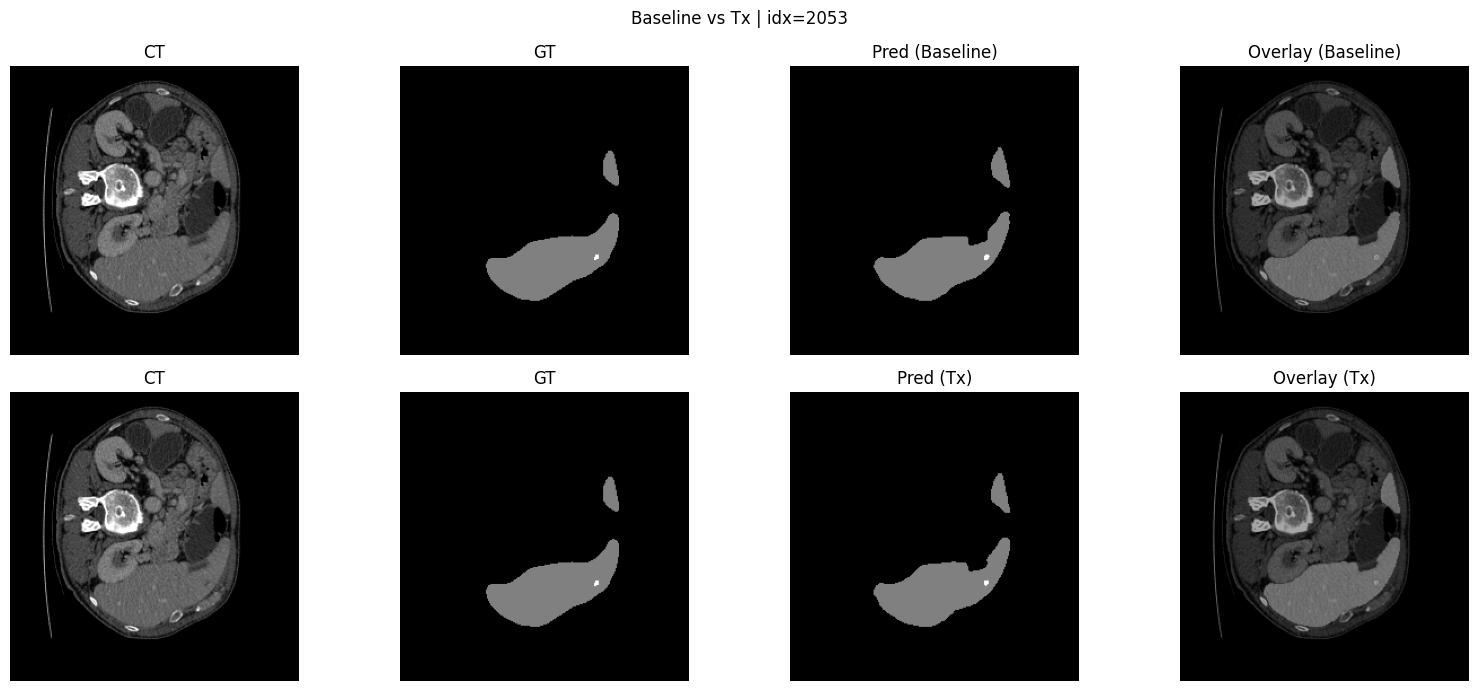

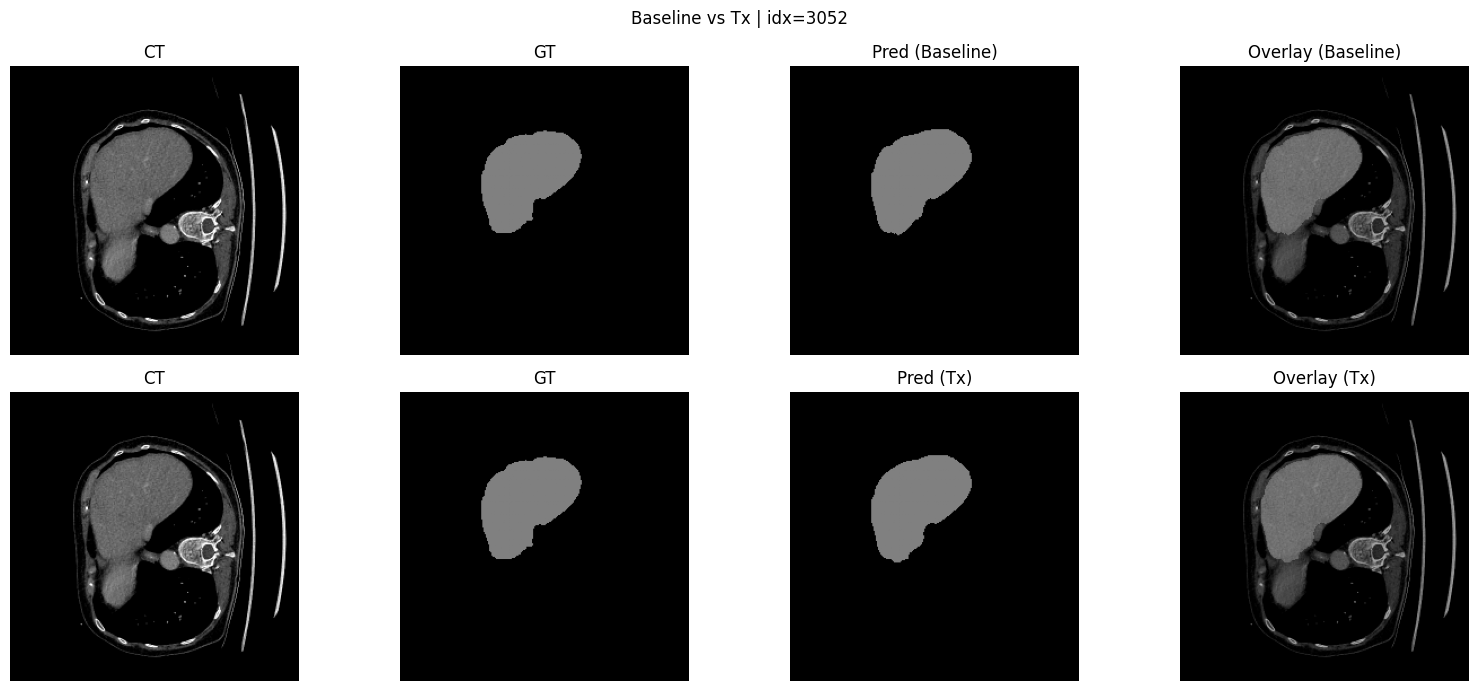

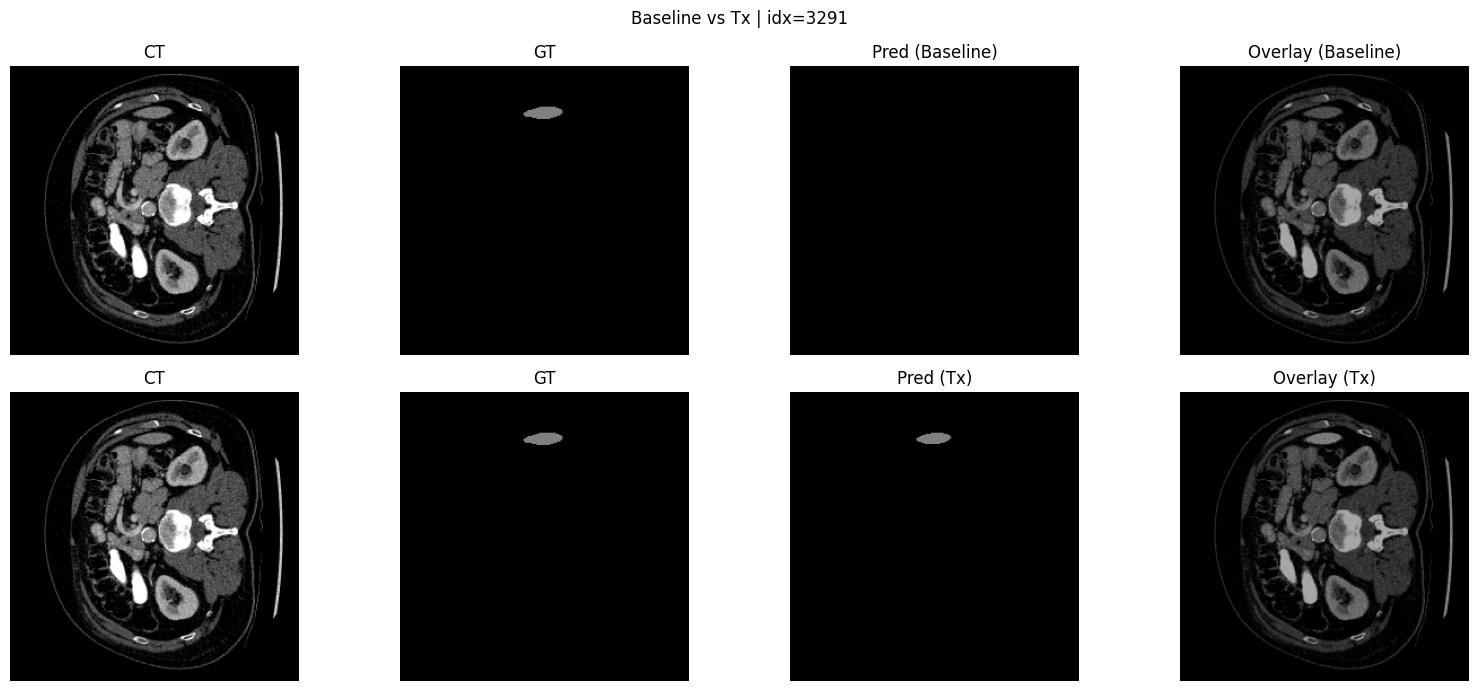

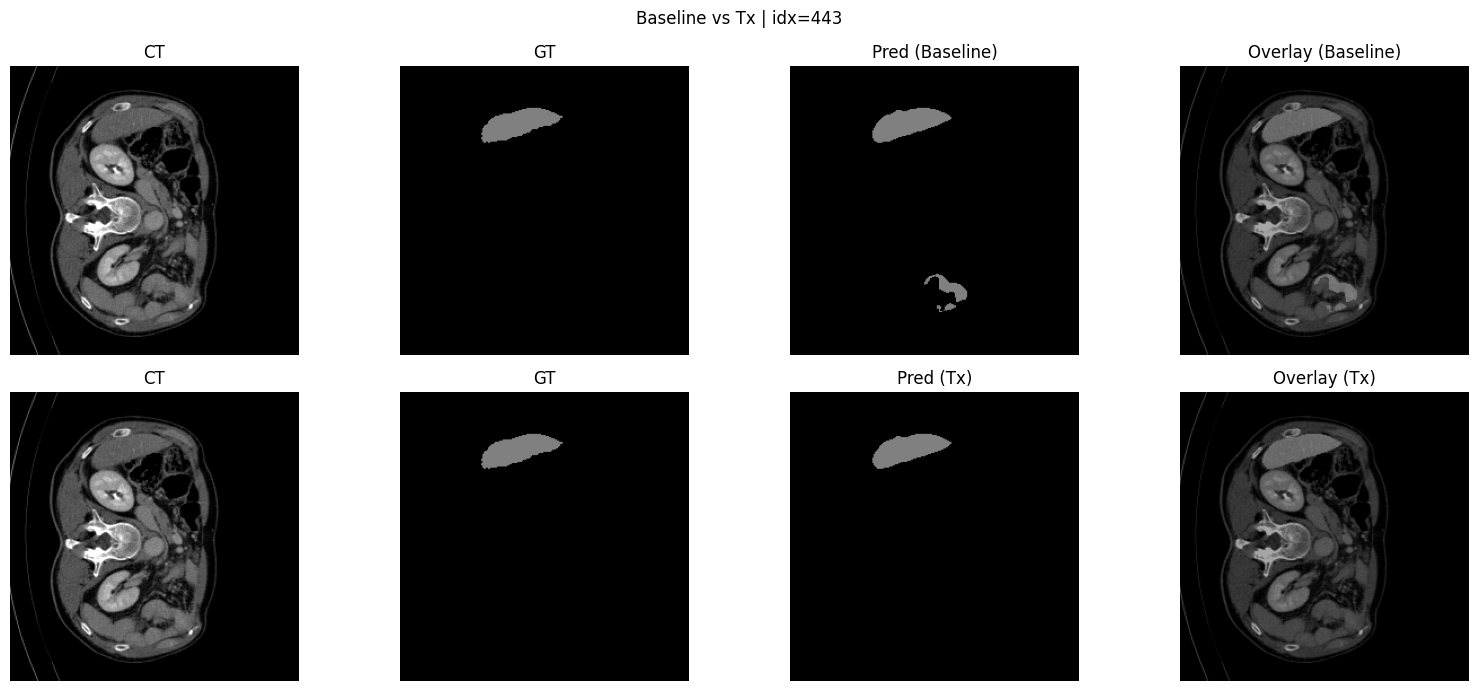

✅ Done. Folder: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/figures/compare_baseline_vs_tx


In [ ]:
# =========================================================
# 10.5b VISUALIZE SIDE-BY-SIDE (BASELINE vs TX) FOR SAME IMAGE + SAVE
# =========================================================
import os
import numpy as np
import matplotlib.pyplot as plt

assert "pred_base" in globals() and "pred_tx" in globals(), "Run Cell 10.4b first"
assert "DIR_FIG" in globals() and "vis_tag" in globals(), "Need DIR_FIG + vis_tag"

def plot_compare_2rows(img2d, gt2d, pr_base2d, pr_tx2d, title=None, save_path=None):
    plt.figure(figsize=(16, 7))

    # Row 1: Baseline
    ax = plt.subplot(2,4,1)
    ax.imshow(img2d, cmap="gray"); ax.set_title("CT"); ax.axis("off")
    ax = plt.subplot(2,4,2)
    ax.imshow(gt2d, vmin=0, vmax=2); ax.set_title("GT"); ax.axis("off")
    ax = plt.subplot(2,4,3)
    ax.imshow(pr_base2d, vmin=0, vmax=2); ax.set_title("Pred (Baseline)"); ax.axis("off")
    ax = plt.subplot(2,4,4)
    ax.imshow(img2d, cmap="gray")
    ax.imshow(pr_base2d, alpha=0.35, vmin=0, vmax=2)
    ax.set_title("Overlay (Baseline)"); ax.axis("off")

    # Row 2: Tx
    ax = plt.subplot(2,4,5)
    ax.imshow(img2d, cmap="gray"); ax.set_title("CT"); ax.axis("off")
    ax = plt.subplot(2,4,6)
    ax.imshow(gt2d, vmin=0, vmax=2); ax.set_title("GT"); ax.axis("off")
    ax = plt.subplot(2,4,7)
    ax.imshow(pr_tx2d, vmin=0, vmax=2); ax.set_title("Pred (Tx)"); ax.axis("off")
    ax = plt.subplot(2,4,8)
    ax.imshow(img2d, cmap="gray")
    ax.imshow(pr_tx2d, alpha=0.35, vmin=0, vmax=2)
    ax.set_title("Overlay (Tx)"); ax.axis("off")

    if title:
        plt.suptitle(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=160, bbox_inches="tight")
    plt.show()

# chọn vài sample để vẽ
np.random.seed(42)
N_SAMPLES = int(globals().get("N_SAMPLES_COMPARE", 6))
idxs = np.random.choice(len(X_test), size=N_SAMPLES, replace=False).tolist()

OUT_DIR = os.path.join(DIR_FIG, "compare_baseline_vs_tx")
os.makedirs(OUT_DIR, exist_ok=True)

print("Saving compare figures to:", OUT_DIR)
for k, idx in enumerate(idxs, start=1):
    img = X_test[idx, :, :, 0]
    gt  = Y_test[idx]
    pb  = pred_base[idx]
    pt  = pred_tx[idx]

    save_path = os.path.join(OUT_DIR, f"compare_{k:02d}_idx{idx}.png")
    title = f"Baseline vs Tx | idx={idx}"
    plot_compare_2rows(img, gt, pb, pt, title=title, save_path=save_path)

print("✅ Done. Folder:", OUT_DIR)

# **Mục 12 – Vẽ & lưu biểu đồ từ CSV history**

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ===== ROOT RUN (đúng theo bạn cung cấp) =====
RUN_ROOT = "/content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633"

CSV_DIR = os.path.join(RUN_ROOT, "csv")
FIG_DIR = os.path.join(RUN_ROOT, "figures")

os.makedirs(FIG_DIR, exist_ok=True)

# ===== CSV PATHS =====
HIST_BASELINE = os.path.join(CSV_DIR, "history_UNet_Baseline.csv")
HIST_TX       = os.path.join(CSV_DIR, "history_UNet_TxBottleneck.csv")

print("Baseline CSV:", HIST_BASELINE)
print("Tx CSV      :", HIST_TX)
print("FIG_DIR     :", FIG_DIR)

Baseline CSV: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv/history_UNet_Baseline.csv
Tx CSV      : /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv/history_UNet_TxBottleneck.csv
FIG_DIR     : /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/figures


## **Dashboard 2×3: Train vs Val (Baseline vs Tx)**

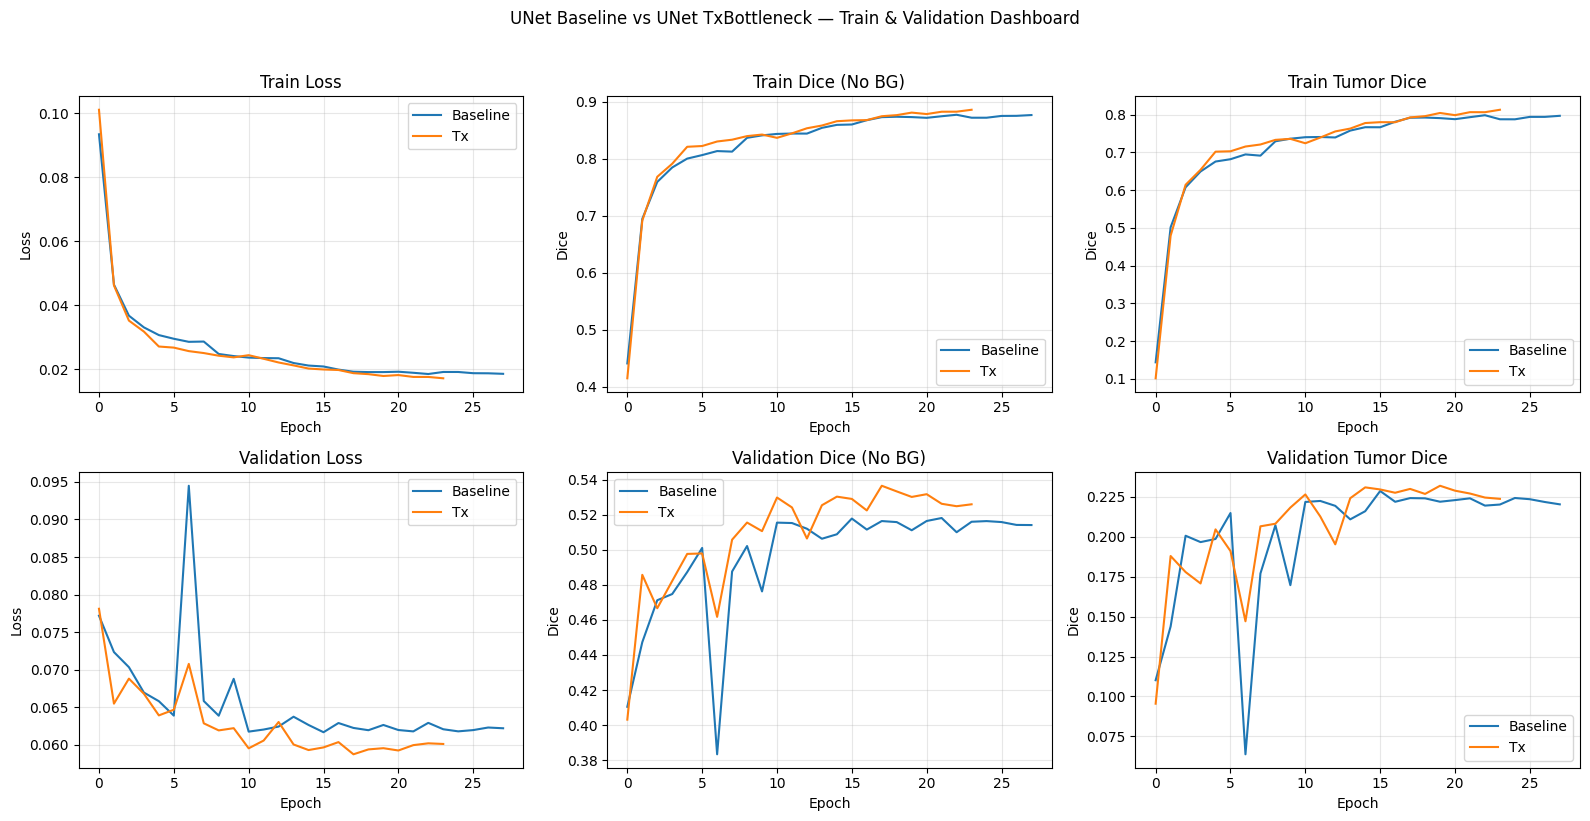

✅ Saved dashboard: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/figures/dashboard_train_val_loss_dice_tumor.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ===== Preconditions =====
assert "df_base" in globals() and "df_tx" in globals(), "Load history CSV first (df_base, df_tx)"
assert "FIG_DIR" in globals(), "FIG_DIR not defined"
assert "dice_key_base" in globals() and "dice_key_tx" in globals(), "Dice keys not defined"

# Helper
def get_col(df, name):
    return df[name].astype(float).values if name in df.columns else None

# ----- TRAIN -----
base_tr_loss  = get_col(df_base, "loss")
tx_tr_loss    = get_col(df_tx,   "loss")

base_tr_dice  = get_col(df_base, dice_key_base)
tx_tr_dice    = get_col(df_tx,   dice_key_tx)

base_tr_tumor = get_col(df_base, tumor_key_base) if "tumor_key_base" in globals() and tumor_key_base else None
tx_tr_tumor   = get_col(df_tx,   tumor_key_tx)   if "tumor_key_tx"   in globals() and tumor_key_tx   else None

# ----- VAL -----
base_va_loss  = get_col(df_base, "val_loss")
tx_va_loss    = get_col(df_tx,   "val_loss")

base_va_dice  = get_col(df_base, f"val_{dice_key_base}")
tx_va_dice    = get_col(df_tx,   f"val_{dice_key_tx}")

base_va_tumor = get_col(df_base, f"val_{tumor_key_base}") if base_tr_tumor is not None else None
tx_va_tumor   = get_col(df_tx,   f"val_{tumor_key_tx}")   if tx_tr_tumor   is not None else None

# ----- Plot -----
plt.figure(figsize=(16, 8))

# ===== ROW 1: TRAIN =====
# Train Loss
ax = plt.subplot(2, 3, 1)
ax.plot(base_tr_loss, label="Baseline")
ax.plot(tx_tr_loss,   label="Tx")
ax.set_title("Train Loss")
ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
ax.grid(alpha=0.3); ax.legend()

# Train Dice
ax = plt.subplot(2, 3, 2)
ax.plot(base_tr_dice, label="Baseline")
ax.plot(tx_tr_dice,   label="Tx")
ax.set_title("Train Dice (No BG)")
ax.set_xlabel("Epoch"); ax.set_ylabel("Dice")
ax.grid(alpha=0.3); ax.legend()

# Train Tumor Dice
ax = plt.subplot(2, 3, 3)
if base_tr_tumor is not None or tx_tr_tumor is not None:
    if base_tr_tumor is not None:
        ax.plot(base_tr_tumor, label="Baseline")
    if tx_tr_tumor is not None:
        ax.plot(tx_tr_tumor, label="Tx")
    ax.legend()
else:
    ax.text(0.5, 0.5, "Tumor Dice\nnot available", ha="center", va="center")
ax.set_title("Train Tumor Dice")
ax.set_xlabel("Epoch"); ax.set_ylabel("Dice")
ax.grid(alpha=0.3)

# ===== ROW 2: VALIDATION =====
# Val Loss
ax = plt.subplot(2, 3, 4)
ax.plot(base_va_loss, label="Baseline")
ax.plot(tx_va_loss,   label="Tx")
ax.set_title("Validation Loss")
ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
ax.grid(alpha=0.3); ax.legend()

# Val Dice
ax = plt.subplot(2, 3, 5)
ax.plot(base_va_dice, label="Baseline")
ax.plot(tx_va_dice,   label="Tx")
ax.set_title("Validation Dice (No BG)")
ax.set_xlabel("Epoch"); ax.set_ylabel("Dice")
ax.grid(alpha=0.3); ax.legend()

# Val Tumor Dice
ax = plt.subplot(2, 3, 6)
if base_va_tumor is not None or tx_va_tumor is not None:
    if base_va_tumor is not None:
        ax.plot(base_va_tumor, label="Baseline")
    if tx_va_tumor is not None:
        ax.plot(tx_va_tumor, label="Tx")
    ax.legend()
else:
    ax.text(0.5, 0.5, "Tumor Dice\nnot available", ha="center", va="center")
ax.set_title("Validation Tumor Dice")
ax.set_xlabel("Epoch"); ax.set_ylabel("Dice")
ax.grid(alpha=0.3)

plt.suptitle("UNet Baseline vs UNet TxBottleneck — Train & Validation Dashboard", y=1.02)
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "dashboard_train_val_loss_dice_tumor.png")
plt.savefig(out_path, dpi=180, bbox_inches="tight")
plt.show()

print("✅ Saved dashboard:", out_path)

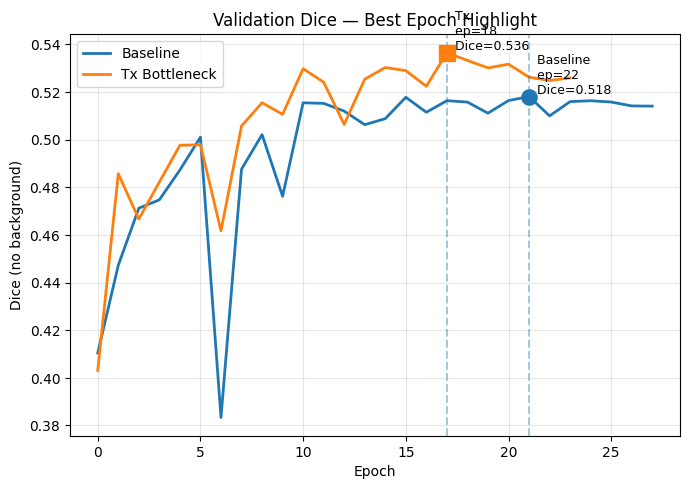

✅ Saved: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/figures/val_dice_best_epoch_marker.png


In [ ]:
plt.figure(figsize=(7,5))

# Curves
plt.plot(base_va_dice, label="Baseline", linewidth=2)
plt.plot(tx_va_dice,   label="Tx Bottleneck", linewidth=2)

# Best epoch markers
plt.scatter(best_ep_base, best_val_dice_base, s=120, marker="o", zorder=5)
plt.scatter(best_ep_tx,   best_val_dice_tx,   s=120, marker="s", zorder=5)

# Vertical lines
plt.axvline(best_ep_base, linestyle="--", alpha=0.4)
plt.axvline(best_ep_tx,   linestyle="--", alpha=0.4)

# Annotation
plt.text(
    best_ep_base, best_val_dice_base,
    f"  Baseline\n  ep={best_ep_base+1}\n  Dice={best_val_dice_base:.3f}",
    va="bottom", fontsize=9
)

plt.text(
    best_ep_tx, best_val_dice_tx,
    f"  Tx\n  ep={best_ep_tx+1}\n  Dice={best_val_dice_tx:.3f}",
    va="bottom", fontsize=9
)

plt.xlabel("Epoch")
plt.ylabel("Dice (no background)")
plt.title("Validation Dice — Best Epoch Highlight")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_path = os.path.join(FIG_DIR, "val_dice_best_epoch_marker.png")
plt.savefig(out_path, dpi=180, bbox_inches="tight")
plt.show()

print("✅ Saved:", out_path)

## **Cell Audit Run – Tổng kiểm tra & so sánh mô hình**

- Tự động quét 1 run trong experiments_lits

- Đọc history_*.csv

- (Nếu có) đọc test_metrics_*.csv

- Quét models/*.keras

- Tìm best epoch theo val_dice_mean_no_bg

- Vẽ biểu đồ so sánh

- Xuất bảng tổng hợp (dùng trực tiếp cho báo cáo)

In [ ]:
RUN_ROOT = "/content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633"

RUN_ROOT : /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633
CSV_DIR  : /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/csv
MODEL_DIR: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/models
Loaded history: UNet_Baseline | epochs = 28
Loaded history: UNet_TxBottleneck | epochs = 24

=== BEST EPOCH SUMMARY ===


model  best_epoch  best_val_dice_mean_no_bg  \
1  UNet_TxBottleneck          18                  0.536446   
0      UNet_Baseline          22                  0.518060   

   train_dice_at_best  val_loss_at_best  
1            0.874741          0.058759  
0            0.874733          0.061805

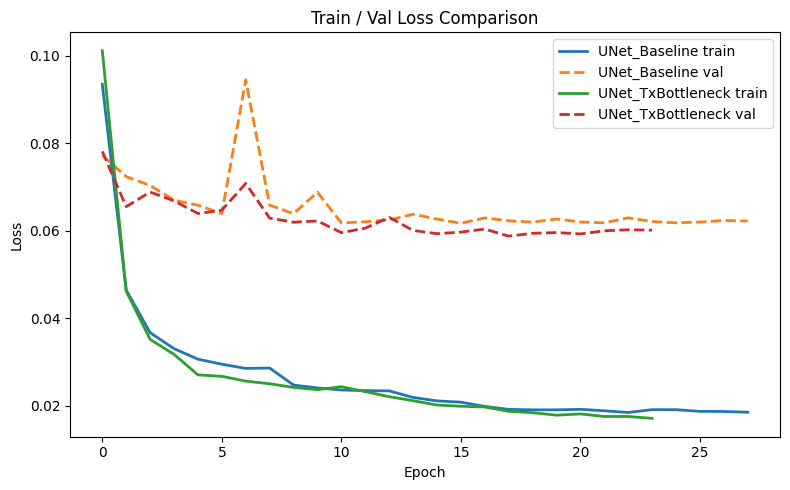

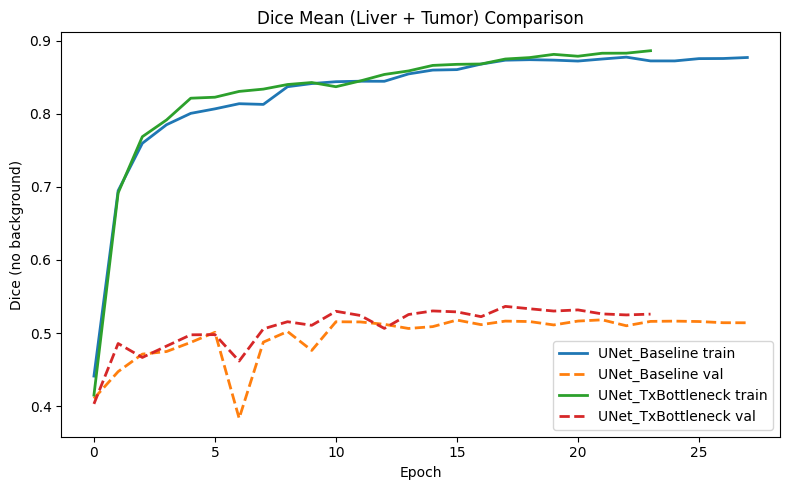


=== TEST METRICS ===


accuracy  dice_liver  dice_mean_no_bg  dice_tumor  iou_liver  \
0  0.992318    0.810476         0.453021    0.095567   0.755945   
1  0.992441    0.837338         0.458054    0.078770   0.787675   
2  0.992318    0.810476         0.453021    0.095567   0.755945   
3  0.992441    0.837338         0.458054    0.078770   0.787675   

   iou_mean_no_bg  iou_tumor      loss          model_tag  \
0        0.414191   0.072438  0.078477      UNet_Baseline   
1        0.423075   0.058476  0.081028  UNet_TxBottleneck   
2        0.414191   0.072438  0.078477      UNet_Baseline   
3        0.423075   0.058476  0.081028  UNet_TxBottleneck   

                           ckpt              model  
0      UNet_Baseline_best.keras      UNet_Baseline  
1  UNet_TxBottleneck_best.keras  UNet_TxBottleneck  
2                           NaN            compare  
3                           NaN            compare


=== CHECKPOINT FILES ===
- UNet_Baseline_best.keras
- UNet_TxBottleneck_best.keras

✅ AUDIT RUN COMPLETED
Figures saved to: /content/drive/MyDrive/Colab Notebooks/2025-2026_HK1/Computer Vision/5_Liver Tumor Segmentation_Phân đoạn khối u gan/Untitled8/experiments_lits/LiTS2D_UNet_vs_UNetTx_CE_Dice/20251230_021633/figures


In [ ]:
# =========================================================
# AUDIT RUN CELL — FINAL CHECK & COMPARISON
# =========================================================
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

# ===== 1. XÁC ĐỊNH RUN ROOT =====
# RUN_ROOT = RUN_ROOT if isinstance(RUN_ROOT, str) else DIRS["run_root"]
CSV_DIR  = os.path.join(RUN_ROOT, "csv")
MODEL_DIR = os.path.join(RUN_ROOT, "models")
FIG_DIR  = os.path.join(RUN_ROOT, "figures")

os.makedirs(FIG_DIR, exist_ok=True)

print("RUN_ROOT :", RUN_ROOT)
print("CSV_DIR  :", CSV_DIR)
print("MODEL_DIR:", MODEL_DIR)

# ===== 2. LOAD HISTORY CSV =====
history_files = sorted(glob.glob(os.path.join(CSV_DIR, "history_*.csv")))
assert len(history_files) >= 1, "❌ No history_*.csv found"

histories = {}
for f in history_files:
    name = os.path.basename(f).replace("history_", "").replace(".csv", "")
    histories[name] = pd.read_csv(f)
    print("Loaded history:", name, "| epochs =", len(histories[name]))

# ===== 3. TÌM BEST EPOCH (theo val_dice_mean_no_bg) =====
summary_rows = []

for name, df in histories.items():
    if "val_dice_mean_no_bg" not in df.columns:
        print(f"⚠️ {name}: val_dice_mean_no_bg not found, skip best-epoch")
        continue

    best_idx = df["val_dice_mean_no_bg"].idxmax()
    summary_rows.append({
        "model": name,
        "best_epoch": int(best_idx) + 1,
        "best_val_dice_mean_no_bg": float(df.loc[best_idx, "val_dice_mean_no_bg"]),
        "train_dice_at_best": float(df.loc[best_idx, "dice_mean_no_bg"]) if "dice_mean_no_bg" in df else None,
        "val_loss_at_best": float(df.loc[best_idx, "val_loss"]) if "val_loss" in df else None,
    })

df_summary = pd.DataFrame(summary_rows).sort_values(
    "best_val_dice_mean_no_bg", ascending=False
)

print("\n=== BEST EPOCH SUMMARY ===")
display(df_summary)

# ===== 4. VẼ OVERLAY LOSS CURVES (Baseline vs Tx) =====
plt.figure(figsize=(8,5))

for name, df in histories.items():
    plt.plot(df["loss"], label=f"{name} train", linewidth=2)
    if "val_loss" in df:
        plt.plot(df["val_loss"], linestyle="--", label=f"{name} val", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train / Val Loss Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "audit_loss_overlay.png"), dpi=160)
plt.show()

# ===== 5. VẼ OVERLAY DICE_MEAN_NO_BG =====
plt.figure(figsize=(8,5))

for name, df in histories.items():
    if "dice_mean_no_bg" in df:
        plt.plot(df["dice_mean_no_bg"], label=f"{name} train", linewidth=2)
    if "val_dice_mean_no_bg" in df:
        plt.plot(df["val_dice_mean_no_bg"], linestyle="--", label=f"{name} val", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Dice (no background)")
plt.title("Dice Mean (Liver + Tumor) Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "audit_dice_mean_overlay.png"), dpi=160)
plt.show()

# ===== 6. (OPTIONAL) LOAD TEST METRICS =====
test_files = sorted(glob.glob(os.path.join(CSV_DIR, "test_metrics_*.csv")))
if len(test_files) > 0:
    dfs = []
    for f in test_files:
        df = pd.read_csv(f)
        df["model"] = os.path.basename(f).replace("test_metrics_", "").replace(".csv", "")
        dfs.append(df)

    df_test = pd.concat(dfs, ignore_index=True)
    print("\n=== TEST METRICS ===")
    display(df_test)
else:
    print("\nℹ️ No test_metrics_*.csv found (skip test comparison)")

# ===== 7. QUÉT CHECKPOINTS =====
ckpts = glob.glob(os.path.join(MODEL_DIR, "*.keras"))
print("\n=== CHECKPOINT FILES ===")
for c in ckpts:
    print("-", os.path.basename(c))

print("\n✅ AUDIT RUN COMPLETED")
print("Figures saved to:", FIG_DIR)